# Future Climatology Changes in Cities across Diverse Climate Zones

# Data Preparation

## Dataset
NASA Earth Exchange Global Daily Downscaled Projections (NEX-GDDP-CMIP6)  
https://ds.nccs.nasa.gov/thredds/catalog/AMES/NEX/GDDP-CMIP6/catalog.html

Latitude Resolution: 0.25 degrees (25 km)  
Longitude Resolution: 0.25 degrees (25 km)

## Cities
Tropical: Miami   
Desert: Phoenix   
Temperate: Los Angeles   
Continental: Chicago

## Time Period
Historical: 1981-2010  
Future: 2071-2100 (SSP2-4.5 & SSP5-8.5)

## Models
ACCESS_CM2: Australian  
GFDL-CM4: American  
UKESM1-0-LL: UK

In [1]:
import re
from siphon.catalog import TDSCatalog
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import dask.array as da
from cartopy import crs as ccrs, feature as cfeature

## ACCESS-CM2

In [ ]:
base_url_template = "https://ds.nccs.nasa.gov/thredds/catalog/AMES/NEX/GDDP-CMIP6/ACCESS-CM2/{scenario}/r1i1p1f1/{variable}/catalog.xml"
scenarios = {
    'historical': (1981, 2010),
    'ssp245': (2071, 2100),
    'ssp585': (2071, 2100)
}
variables = ['tas', 'tasmax', 'tasmin', 'pr', 'hurs', 'sfcWind']
year_pattern = re.compile(r'_gn_(\d{4})\.nc$')

datasets = {}

for scenario, (start_year, end_year) in scenarios.items():
    all_data_urls = []

    for var in variables:
        catalog_url = base_url_template.format(scenario=scenario, variable=var)
        catalog = TDSCatalog(catalog_url)
        
        for dataset_name in catalog.datasets:
            match = year_pattern.search(dataset_name)
            if match:
                year = int(match.group(1))
                if start_year <= year <= end_year:
                    data_urls = catalog.datasets[dataset_name].access_urls['OPENDAP']
                    all_data_urls.append(data_urls)
    
    datasets[scenario] = xr.open_mfdataset(all_data_urls, combine='by_coords')

Accesscm2_historical = datasets['historical']
Accesscm2_ssp245 = datasets['ssp245']
Accesscm2_ssp585 = datasets['ssp585']

## GFDL-CM4

In [ ]:
base_url_template = "https://ds.nccs.nasa.gov/thredds/catalog/AMES/NEX/GDDP-CMIP6/GFDL-CM4/{scenario}/r1i1p1f1/{variable}/catalog.xml"
scenarios = {
    'historical': (1981, 2010),
    'ssp245': (2071, 2100),
    'ssp585': (2071, 2100)
}
variables = ['tas', 'tasmax', 'tasmin', 'pr', 'hurs', 'sfcWind']
year_pattern = re.compile(r'_gr1_(\d{4})\.nc$')

datasets = {}

for scenario, (start_year, end_year) in scenarios.items():
    all_data_urls = []

    for var in variables:
        catalog_url = base_url_template.format(scenario=scenario, variable=var)
        catalog = TDSCatalog(catalog_url)
        
        for dataset_name in catalog.datasets:
            match = year_pattern.search(dataset_name)
            if match:
                year = int(match.group(1))
                if start_year <= year <= end_year:
                    data_urls = catalog.datasets[dataset_name].access_urls['OPENDAP']
                    all_data_urls.append(data_urls)
    
    datasets[scenario] = xr.open_mfdataset(all_data_urls, combine='by_coords')

GFDL_historical = datasets['historical']
GFDL_245 = datasets['ssp245']
GFDL_585 = datasets['ssp585']

## UKESM1-0-LL

In [ ]:
base_url_template = "https://ds.nccs.nasa.gov/thredds/catalog/AMES/NEX/GDDP-CMIP6/UKESM1-0-LL/{scenario}/r1i1p1f2/{variable}/catalog.xml"
scenarios = {
    'historical': (1981, 2010),
    'ssp245': (2071, 2100),
    'ssp585': (2071, 2100)
}
variables = ['tas', 'tasmax', 'tasmin', 'pr', 'hurs', 'sfcWind']
year_pattern = re.compile(r'_gn_(\d{4})\.nc$')

datasets = {}
for scenario, (start_year, end_year) in scenarios.items():
    all_data_urls = []

    for var in variables:
        catalog_url = base_url_template.format(scenario=scenario, variable=var)
        catalog = TDSCatalog(catalog_url)
        
        for dataset_name in catalog.datasets:
            match = year_pattern.search(dataset_name)
            if match:
                year = int(match.group(1))
                if start_year <= year <= end_year:
                    data_urls = catalog.datasets[dataset_name].access_urls['OPENDAP']
                    all_data_urls.append(data_urls)
    
    datasets[scenario] = xr.open_mfdataset(all_data_urls, combine='by_coords')

UKESM_historical = datasets['historical']
UKESM_245 = datasets['ssp245']
UKESM_585 = datasets['ssp585']

# 1. Impact of Humidity on Future Heat Stress

## 1.1 City level

In [6]:
def preprocess_dataset(ds):
    ds = ds.convert_calendar('standard', align_on='year')
    return ds

In [7]:
def calculate_wet_bulb_temperature(temp_kelvin, relative_humidity):
    temp_celsius = temp_kelvin - 273.15
    e_s = 6.105 * np.exp(17.27 * temp_celsius / (237.7 + temp_celsius))
    e = (relative_humidity / 100.0) * e_s
    wet_bulb_celsius = temp_celsius * np.arctan(0.151977 * ((relative_humidity + 8.313659) ** 0.5)) + \
                       np.arctan(temp_celsius + relative_humidity) - \
                       np.arctan(relative_humidity - 1.676331) + \
                       0.00391838 * (relative_humidity ** 1.5) * np.arctan(0.023101 * relative_humidity) - 4.686035

    return wet_bulb_celsius

/tmp/ipykernel_1026/744620316.py:5: RuntimeWarning: invalid value encountered in scalar power
  wet_bulb_celsius = temp_celsius * np.arctan(0.151977 * ((relative_humidity + 8.313659) ** 0.5)) + \
/tmp/ipykernel_1026/744620316.py:8: RuntimeWarning: invalid value encountered in scalar power
  0.00391838 * (relative_humidity ** 1.5) * np.arctan(0.023101 * relative_humidity) - 4.686035
/tmp/ipykernel_1026/744620316.py:8: RuntimeWarning: invalid value encountered in scalar power
  0.00391838 * (relative_humidity ** 1.5) * np.arctan(0.023101 * relative_humidity) - 4.686035
/tmp/ipykernel_1026/744620316.py:5: RuntimeWarning: invalid value encountered in scalar power
  wet_bulb_celsius = temp_celsius * np.arctan(0.151977 * ((relative_humidity + 8.313659) ** 0.5)) + \
/tmp/ipykernel_1026/744620316.py:8: RuntimeWarning: invalid value encountered in scalar power
  0.00391838 * (relative_humidity ** 1.5) * np.arctan(0.023101 * relative_humidity) - 4.686035
/tmp/ipykernel_1026/744620316.py:5: Runti

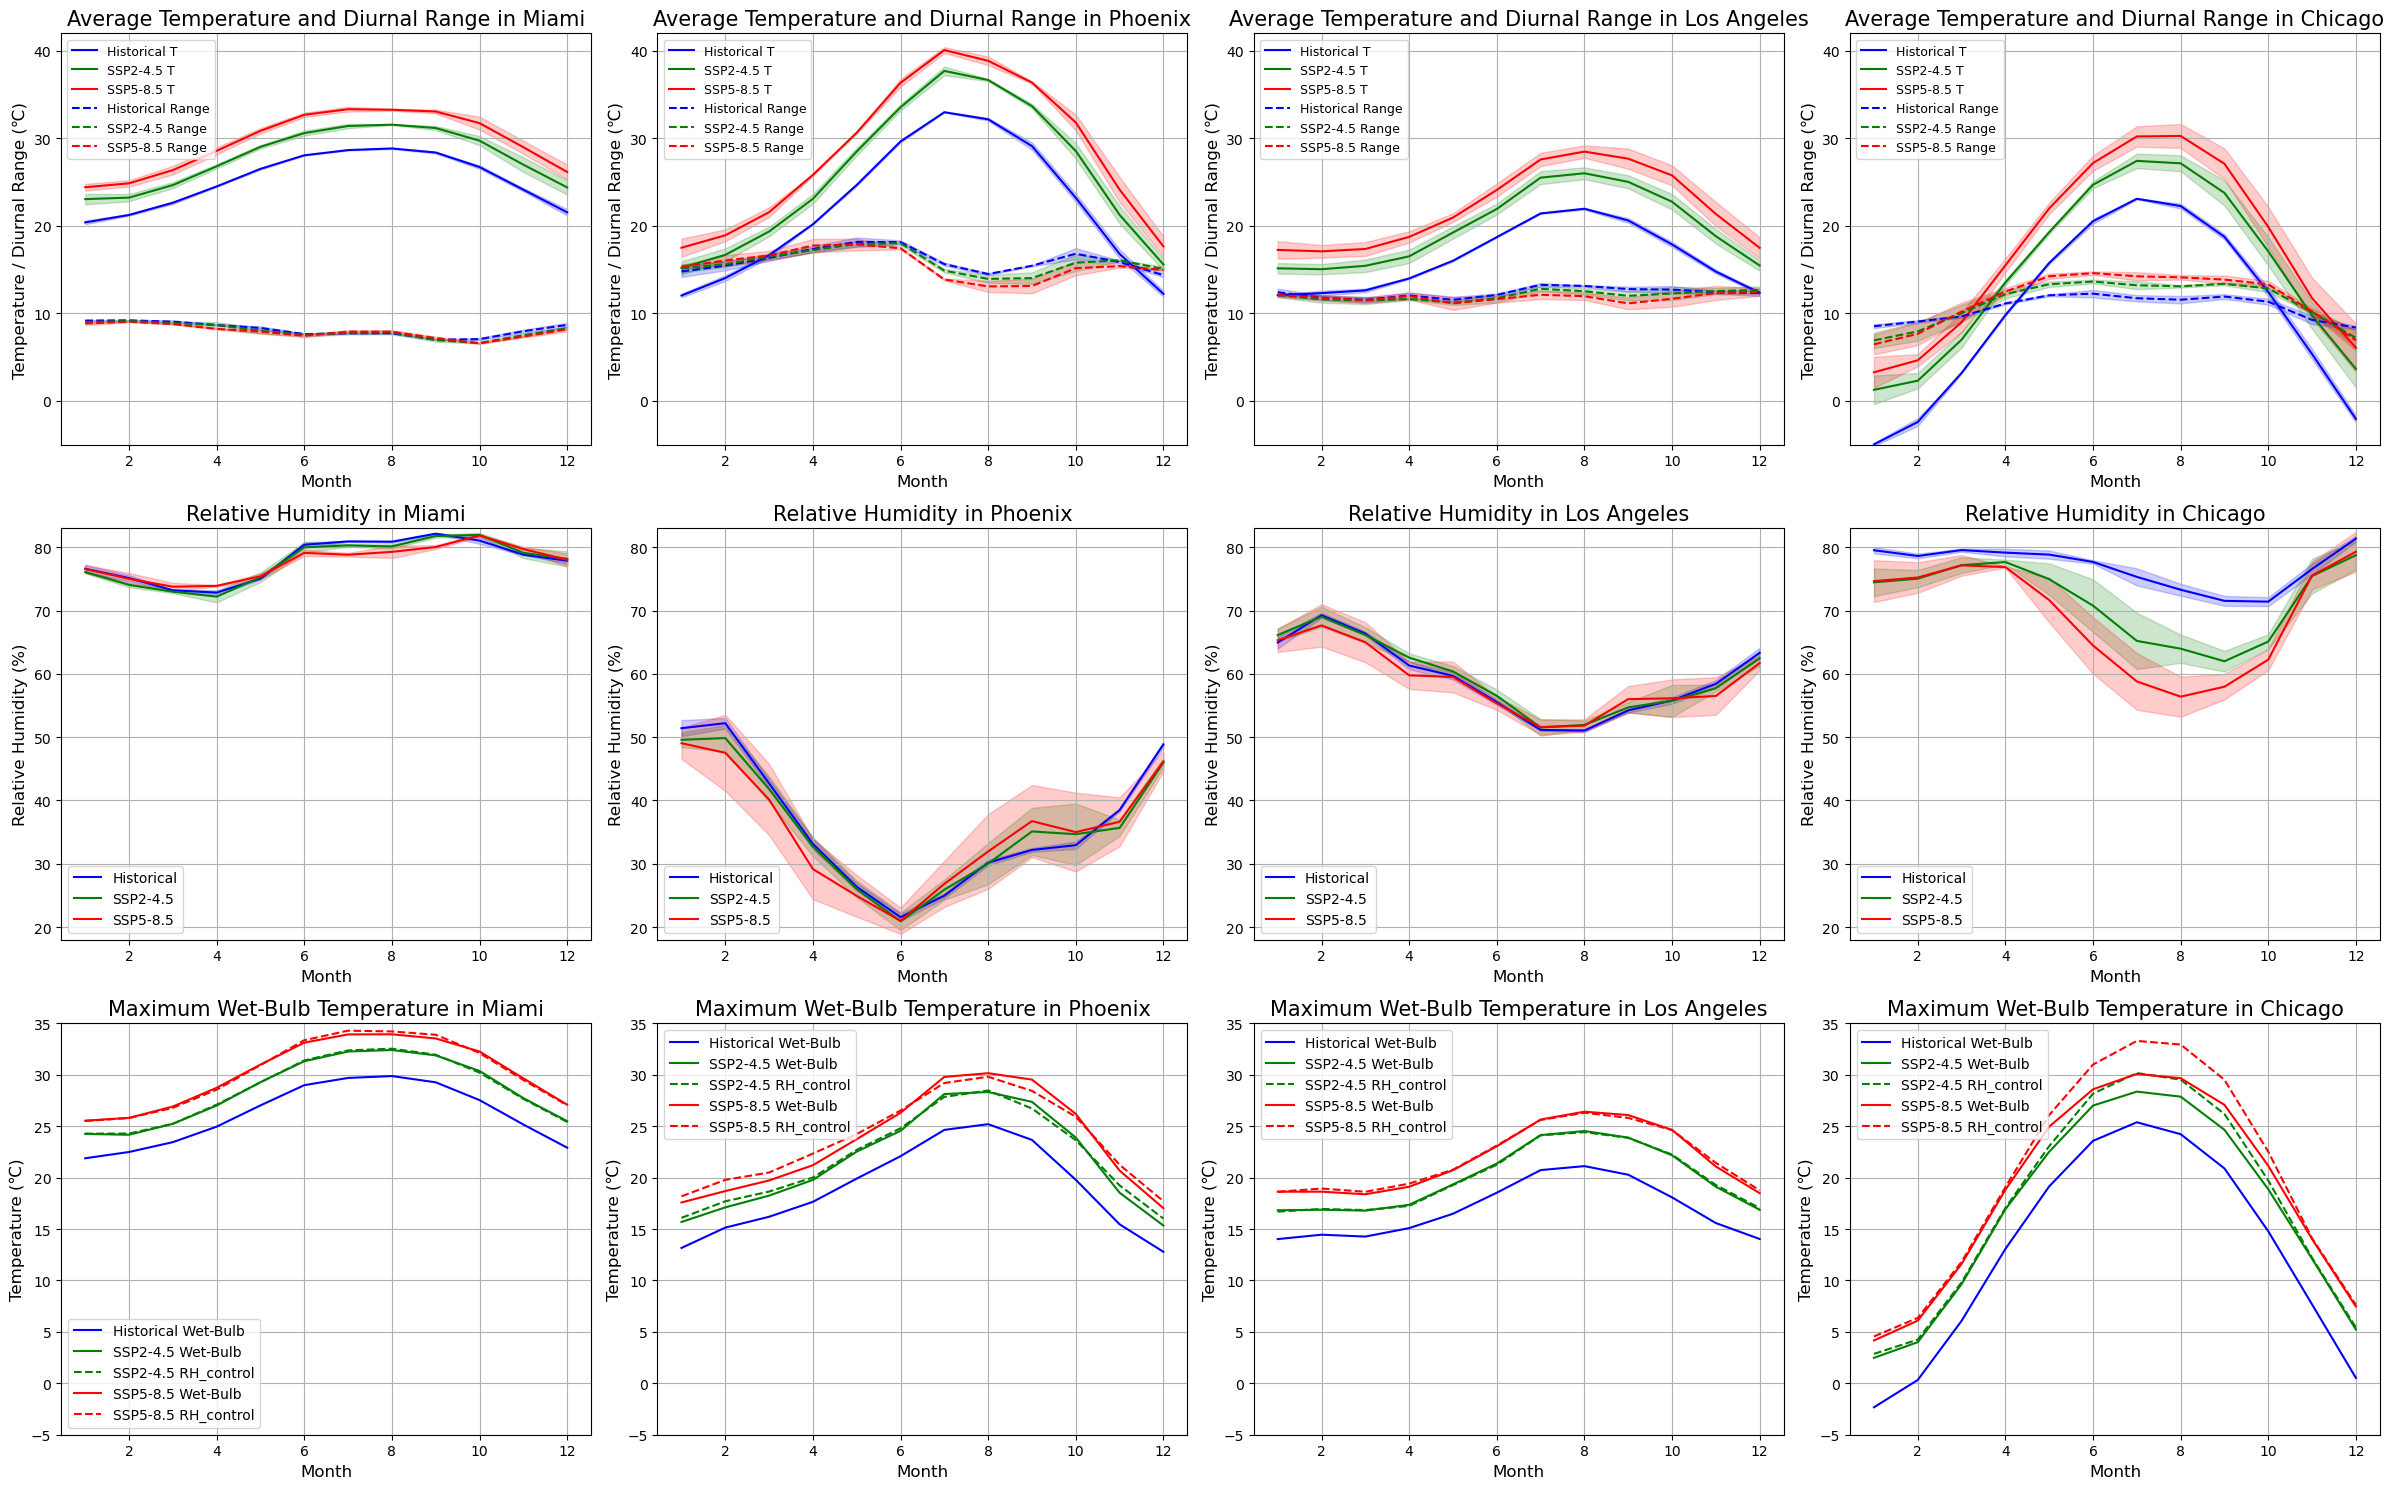

In [8]:
cities = ['MI', 'PX', 'LA', 'CG']
titles = {'MI': 'Miami', 'PX': 'Phoenix', 'LA': 'Los Angeles', 'CG': 'Chicago'}

fig, axes = plt.subplots(3, 4, figsize=(24, 15), constrained_layout=True)

for i, city in enumerate(cities):
    hist = xr.open_mfdataset([f'A_{city}_hist.nc', f'G_{city}_hist.nc', f'U_{city}_hist.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    ssp245 = xr.open_mfdataset([f'A_{city}_245.nc', f'G_{city}_245.nc', f'U_{city}_245.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    ssp585 = xr.open_mfdataset([f'A_{city}_585.nc', f'G_{city}_585.nc', f'U_{city}_585.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    
    tas_hist = hist['tas'].groupby('time.month').mean(dim=['time', 'model']) - 273.15
    tas_245 = ssp245['tas'].groupby('time.month').mean(dim=['time', 'model']) - 273.15
    tas_585 = ssp585['tas'].groupby('time.month').mean(dim=['time', 'model']) - 273.15
    tas_hist_std = hist['tas'].groupby('time.month').mean(dim='time').std(dim='model')
    tas_245_std = ssp245['tas'].groupby('time.month').mean(dim='time').std(dim='model')
    tas_585_std = ssp585['tas'].groupby('time.month').mean(dim='time').std(dim='model')

    range_hist = hist['range'].groupby('time.month').mean(dim=['time', 'model'])
    range_245 = ssp245['range'].groupby('time.month').mean(dim=['time', 'model'])
    range_585 = ssp585['range'].groupby('time.month').mean(dim=['time', 'model'])
    range_hist_std = hist['range'].groupby('time.month').mean(dim='time').std(dim='model')
    range_245_std = ssp245['range'].groupby('time.month').mean(dim='time').std(dim='model')
    range_585_std = ssp585['range'].groupby('time.month').mean(dim='time').std(dim='model')

    hurs_hist = hist['hurs'].groupby('time.month').mean(dim=['time', 'model'])
    hurs_245 = ssp245['hurs'].groupby('time.month').mean(dim=['time', 'model'])
    hurs_585 = ssp585['hurs'].groupby('time.month').mean(dim=['time', 'model'])
    hurs_hist_std = hist['hurs'].groupby('time.month').mean(dim='time').std(dim='model')
    hurs_245_std = ssp245['hurs'].groupby('time.month').mean(dim='time').std(dim='model')
    hurs_585_std = ssp585['hurs'].groupby('time.month').mean(dim='time').std(dim='model')

    months = tas_hist['month'].values
    
    # 1st line: avg ras and range
    ax1 = axes[0, i]
    ax1.plot(months, tas_hist, label='Historical T', color='blue')
    ax1.plot(months, tas_245, label='SSP2-4.5 T', color='green')
    ax1.plot(months, tas_585, label='SSP5-8.5 T', color='red')
    ax1.fill_between(months, tas_hist - tas_hist_std, tas_hist + tas_hist_std, color='blue', alpha=0.2)
    ax1.fill_between(months, tas_245 - tas_245_std, tas_245 + tas_245_std, color='green', alpha=0.2)
    ax1.fill_between(months, tas_585 - tas_585_std, tas_585 + tas_585_std, color='red', alpha=0.2)
    
    ax1.plot(months, range_hist, label='Historical Range', color='blue', linestyle='--')
    ax1.plot(months, range_245, label='SSP2-4.5 Range', color='green', linestyle='--')
    ax1.plot(months, range_585, label='SSP5-8.5 Range', color='red', linestyle='--')
    ax1.fill_between(months, range_hist - range_hist_std, range_hist + range_hist_std, color='blue', alpha=0.2)
    ax1.fill_between(months, range_245 - range_245_std, range_245 + range_245_std, color='green', alpha=0.2)
    ax1.fill_between(months, range_585 - range_585_std, range_585 + range_585_std, color='red', alpha=0.2)

    ax1.set_ylim(-5, 42)
    ax1.set_xlabel('Month', fontsize=12)
    ax1.set_ylabel('Temperature / Diurnal Range (℃)', fontsize=12)
    ax1.set_title(f'Average Temperature and Diurnal Range in {titles[city]}', fontsize=15)
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True)

    # 2st line: humidity
    ax1 = axes[1, i]
    ax1.plot(months, hurs_hist, label='Historical', color='blue')
    ax1.plot(months, hurs_245, label='SSP2-4.5', color='green')
    ax1.plot(months, hurs_585, label='SSP5-8.5', color='red')
    ax1.fill_between(months, hurs_hist - hurs_hist_std, hurs_hist + hurs_hist_std, color='blue', alpha=0.2)
    ax1.fill_between(months, hurs_245 - hurs_245_std, hurs_245 + hurs_245_std, color='green', alpha=0.2)
    ax1.fill_between(months, hurs_585 - hurs_585_std, hurs_585 + hurs_585_std, color='red', alpha=0.2)
    ax1.set_ylim(18, 83)
    ax1.set_xlabel('Month', fontsize=12)
    ax1.set_ylabel('Relative Humidity (%)', fontsize=12)
    ax1.set_title(f'Relative Humidity in {titles[city]}', fontsize=15)
    ax1.legend(loc='lower left', bbox_to_anchor=(0.0, 0.0))
    ax1.grid(True)

    # 3rd line: wetbulb-temperature
    wetbulb_hist = []
    wetbulb_245 = []
    wetbulb_585 = []
    wetbulb_245_control = []
    wetbulb_585_control = []
    for j in range(3):
        hist_model, ssp245_model, ssp585_model = hist.isel(model = j), ssp245.isel(model = j), ssp585.isel(model = j)
        wetbulb_hist.append(xr.apply_ufunc(calculate_wet_bulb_temperature, hist_model['tasmax'], hist_model['hurs'], input_core_dims=[[], []], vectorize=True, dask="parallelized", output_dtypes=[float]))
        wetbulb_245.append(xr.apply_ufunc(calculate_wet_bulb_temperature, ssp245_model['tasmax'], ssp245_model['hurs'], input_core_dims=[[], []], vectorize=True, dask="parallelized", output_dtypes=[float]))
        wetbulb_585.append(xr.apply_ufunc(calculate_wet_bulb_temperature, ssp585_model['tasmax'], ssp585_model['hurs'], input_core_dims=[[], []], vectorize=True, dask="parallelized", output_dtypes=[float]))
        
        #对照
        hurs_control = hist_model['hurs'].copy()
        hurs_control['time'] = ssp245['tasmax']['time']
        
        wetbulb_245_control.append(xr.apply_ufunc(calculate_wet_bulb_temperature, ssp245_model['tasmax'], hurs_control, input_core_dims=[[], []], vectorize=True, dask="parallelized", output_dtypes=[float]))
        wetbulb_585_control.append(xr.apply_ufunc(calculate_wet_bulb_temperature, ssp585_model['tasmax'], hurs_control, input_core_dims=[[], []], vectorize=True, dask="parallelized", output_dtypes=[float]))

    wetbulb_hist = xr.concat([wetbulb_hist[0], wetbulb_hist[1], wetbulb_hist[2]], dim='model')
    wetbulb_245 = xr.concat([wetbulb_245[0], wetbulb_245[1], wetbulb_245[2]], dim='model')
    wetbulb_585 = xr.concat([wetbulb_585[0], wetbulb_585[1], wetbulb_585[2]], dim='model')
    wetbulb_245_control = xr.concat([wetbulb_245_control[0], wetbulb_245_control[1], wetbulb_245_control[2]], dim='model')
    wetbulb_585_control = xr.concat([wetbulb_585_control[0], wetbulb_585_control[1], wetbulb_585_control[2]], dim='model')

    wetbulb_clim_hist = wetbulb_hist.groupby('time.month').mean(dim=['time', 'model'])
    wetbulb_clim_245 = wetbulb_245.groupby('time.month').mean(dim=['time', 'model'])
    wetbulb_clim_585 = wetbulb_585.groupby('time.month').mean(dim=['time', 'model'])
    wetbulb_clim_245_control = wetbulb_245_control.groupby('time.month').mean(dim=['time', 'model'])
    wetbulb_clim_585_control = wetbulb_585_control.groupby('time.month').mean(dim=['time', 'model'])
    # wetbulb_clim_hist_std = wetbulb_hist.groupby('time.month').mean(dim='time').std(dim='model')
    # wetbulb_clim_245_std = wetbulb_hist.groupby('time.month').mean(dim='time').std(dim='model')
    # wetbulb_clim_585_std = wetbulb_hist.groupby('time.month').mean(dim='time').std(dim='model')

    ax1 = axes[2, i]
    ax1.plot(months, wetbulb_clim_hist, label='Historical Wet-Bulb', color='blue')
    ax1.plot(months, wetbulb_clim_245, label='SSP2-4.5 Wet-Bulb', color='green')
    ax1.plot(months, wetbulb_clim_245_control, label='SSP2-4.5 RH_control', linestyle='--', color='green')
    ax1.plot(months, wetbulb_clim_585, label='SSP5-8.5 Wet-Bulb', color='red')
    ax1.plot(months, wetbulb_clim_585_control, label='SSP5-8.5 RH_control', linestyle='--', color='red')
    ax1.set_title(f'Maximum Wet-Bulb Temperature in {titles[city]}', fontsize=15)
    ax1.set_xlabel('Month', fontsize=12)
    ax1.set_ylabel('Temperature (℃)', fontsize=12)
    ax1.set_ylim(-5, 35)
    ax1.legend(loc='upper left')
    ax1.grid(True)
    if i == 0:
        ax1.legend(loc='lower left', bbox_to_anchor=(0.0, 0.0))

plt.tight_layout()
plt.show()

## 1.2 US countrywide

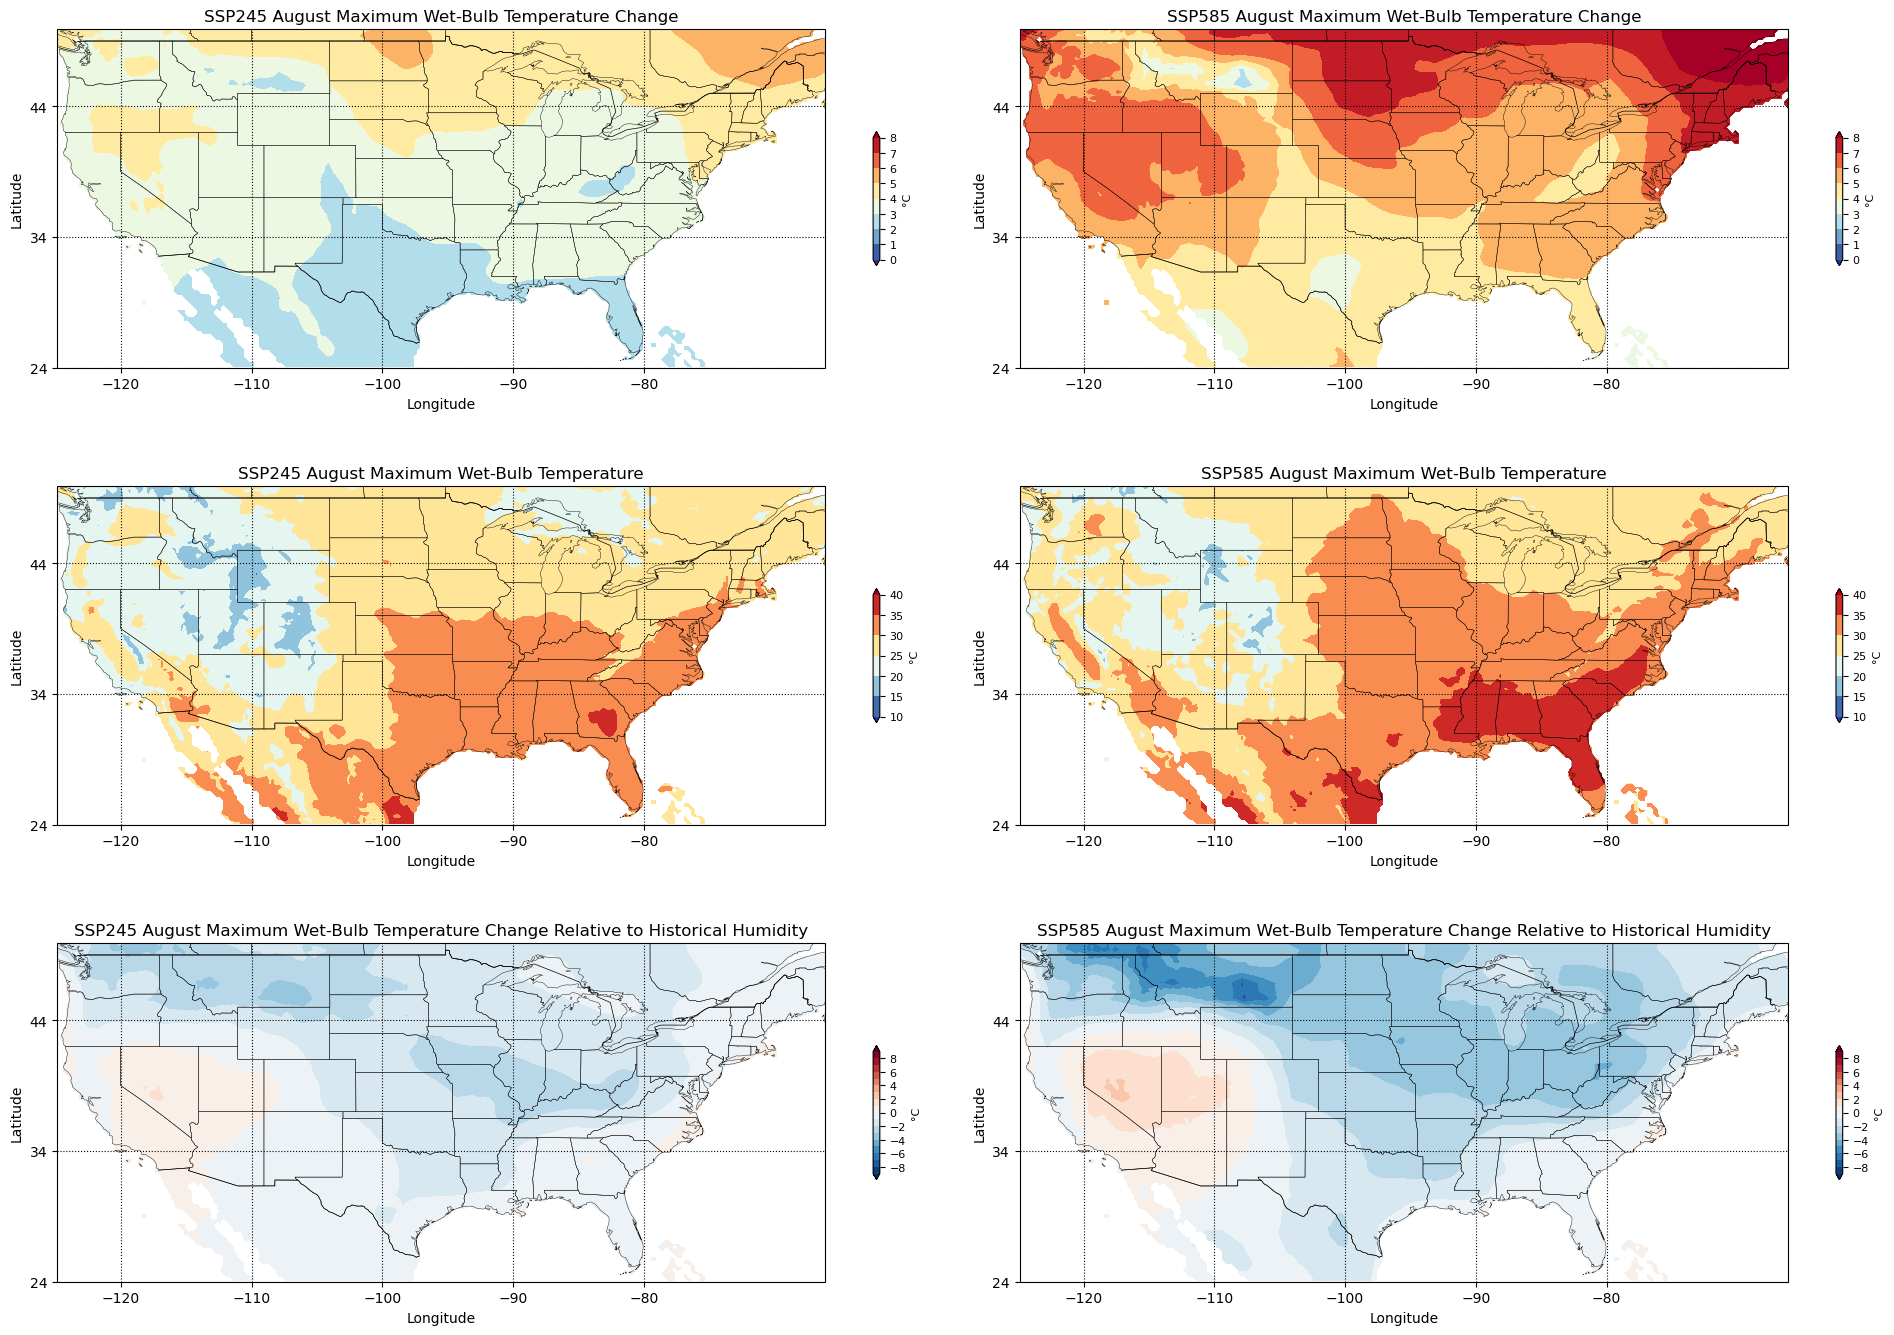

In [21]:
scenarios = ['245', '585']
fig, axes = plt.subplots(3, 2, figsize=(20, 14), subplot_kw={'projection': ccrs.PlateCarree()})

for i, scenario in enumerate(scenarios):
    hist = xr.open_mfdataset(['A_us_hist.nc', 'G_us_hist.nc', 'U_us_hist.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    ssp = xr.open_mfdataset([f'A_us_{scenario}.nc', f'G_us_{scenario}.nc', f'U_us_{scenario}.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')    

    wetbulb_change = ssp.wetbulb.groupby('time.month').mean(dim=['time', 'model']).isel(month=7) - hist.wetbulb.groupby('time.month').mean(dim=['time', 'model']).isel(month=7)

    # 1st line: wetbulb change relative to historical
    ax1 = axes[0, i]
    lon = ssp.lon.values
    lat = ssp.lat.values
    clevels = np.arange(0, 9, 1)
    c0 = ax1.contourf(lon, lat, wetbulb_change, clevels, cmap='RdYlBu_r', extend='both')
    ax1.grid(linestyle=':', linewidth=0.8, color='k')
    ax1.set_xlabel('Longitude', fontsize=10)
    ax1.set_ylabel('Latitude', fontsize=10)
    ax1.set_title(f'SSP{scenario} August Maximum Wet-Bulb Temperature Change', fontsize=12)
    ax1.set_xticks(np.arange(-120, -70, 10), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(24, 50, 10), crs=ccrs.PlateCarree())
    ax1.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax1.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
    cbar = fig.colorbar(c0, ax=ax1, shrink=0.3)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('°C', fontsize=8)

    #第二行: wetbulb
    wetbulb = ssp.wetbulb.groupby('time.month').mean(dim=['time', 'model']).isel(month=7)
    
    ax1 = axes[1, i]
    lon = ssp.lon.values
    lat = ssp.lat.values
    clevels = np.arange(10, 45, 5)
    c0 = ax1.contourf(lon, lat, wetbulb, clevels, cmap='RdYlBu_r', extend='both')
    ax1.grid(linestyle=':', linewidth=0.8, color='k')
    ax1.set_xlabel('Longitude', fontsize=10)
    ax1.set_ylabel('Latitude', fontsize=10)
    ax1.set_title(f'SSP{scenario} August Maximum Wet-Bulb Temperature', fontsize=12)
    ax1.set_xticks(np.arange(-120, -70, 10), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(24, 50, 10), crs=ccrs.PlateCarree())
    ax1.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax1.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
    cbar = fig.colorbar(c0, ax=ax1, shrink=0.3)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('°C', fontsize=8)

    #第三行: wetbulb change relative to humidity change
    wetbulb_change_rh = ssp.wetbulb.groupby('time.month').mean(dim=['time', 'model']).isel(month=7) - ssp.wetbulb_control.groupby('time.month').mean(dim=['time', 'model']).isel(month=7)

    ax1 = axes[2, i]
    clevels = np.linspace(-9, 9, 19)
    c0 = ax1.contourf(lon, lat, wetbulb_change_rh, clevels, cmap='RdBu_r', extend='both')
    ax1.grid(linestyle=':', linewidth=0.8, color='k')
    ax1.set_xlabel('Longitude', fontsize=10)
    ax1.set_ylabel('Latitude', fontsize=10)
    ax1.set_title(f'SSP{scenario} August Maximum Wet-Bulb Temperature Change Relative to Historical Humidity', fontsize=12)
    ax1.set_xticks(np.arange(-120, -70, 10), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(24, 50, 10), crs=ccrs.PlateCarree())
    ax1.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax1.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
    cbar = fig.colorbar(c0, ax=ax1, shrink=0.3)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('°C', fontsize=8)

plt.tight_layout()
plt.show()

# 2. Change of Future Extreme Events

## 2.1 Heatwave and Extreme Precipitation
#### Heatwave Duration Index: Sum of all days with tasmax exceeding 95% quantile of historical climatology  
#### Extreme Precipitation Days: Sum of all days with precip exceeding 95% quantile of historical climatology

In [4]:
def calculate_heatwave_index(data, threshold_quantile=0.95):
    tasmax = data['tasmax']
    
    def calculate_exceedance(group):
        month = group.time.dt.month.values[0]
        threshold = monthly_threshold.sel(month=month)
        return (group > threshold).sum(dim='time')
    
    heatwave_days = (tasmax.groupby('time.year').map(lambda x: x.groupby('time.month').map(calculate_exceedance)))
    
    result = heatwave_days.to_dataset(name='heatwave_days')
    result = result.stack(time=("year", "month"))
    time_index = pd.to_datetime(
        {
            "year": result["year"].values,
            "month": result["month"].values,
            "day": 1 
        }
    )
    result = result.drop_vars(["time", "year", "month"])
    result = result.assign_coords(time=("time", time_index))
    
    return result

In [5]:
def calculate_extreme_precip(data):
    precip = data['pr'] * 86400
    
    def calculate_exceedance(group):
        month = group.time.dt.month.values[0]
        threshold = monthly_threshold.sel(month=month)
        return (group > threshold).sum(dim='time')
    
    precip_days = (precip.groupby('time.year').map(lambda x: x.groupby('time.month').map(calculate_exceedance)))
    
    result = precip_days.to_dataset(name='precip_days')
    result = result.stack(time=("year", "month"))
    time_index = pd.to_datetime(
        {
            "year": result["year"].values,
            "month": result["month"].values,
            "day": 1 
        }
    )
    result = result.drop_vars(["time", "year", "month"])
    result = result.assign_coords(time=("time", time_index))
    
    return result

/tmp/ipykernel_5094/32143133.py:147: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


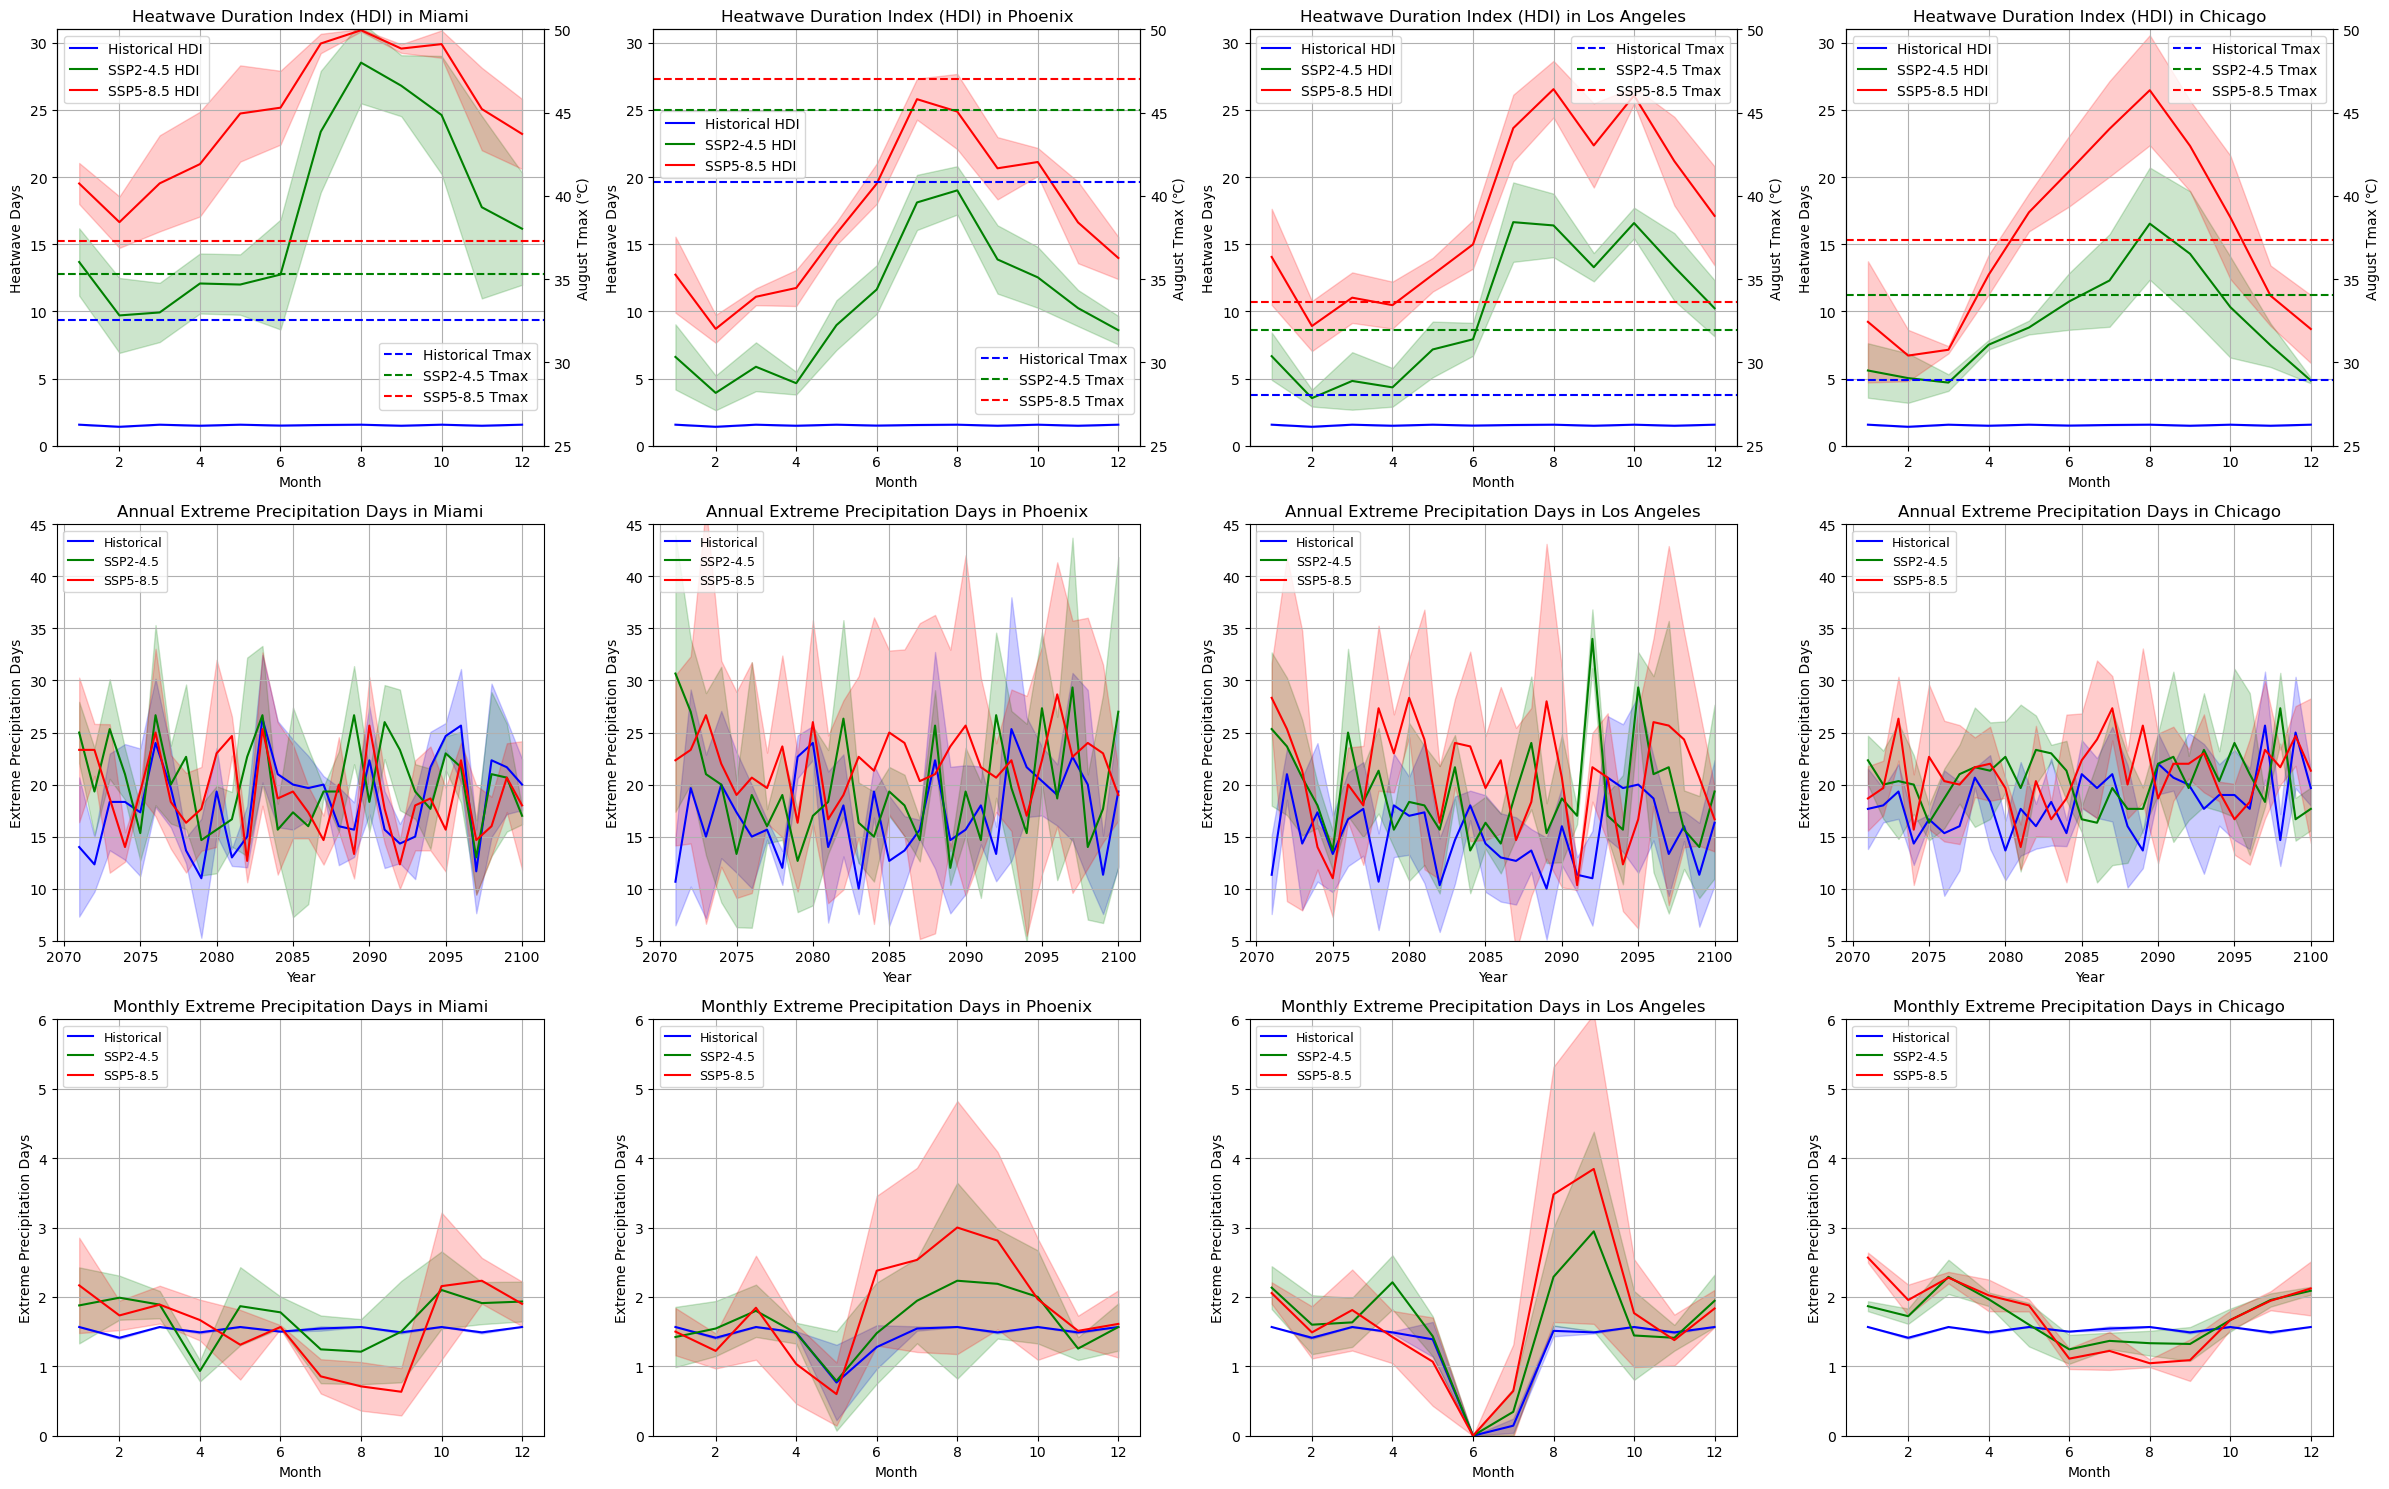

In [9]:
cities = ['MI', 'PX', 'LA', 'CG']
titles = {'MI': 'Miami', 'PX': 'Phoenix', 'LA': 'Los Angeles', 'CG': 'Chicago'}

fig, axes = plt.subplots(3, 4, figsize=(24, 15), constrained_layout=True)

for i, city in enumerate(cities):
    hist = xr.open_mfdataset([f'A_{city}_hist.nc', f'G_{city}_hist.nc', f'U_{city}_hist.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    ssp245 = xr.open_mfdataset([f'A_{city}_245.nc', f'G_{city}_245.nc', f'U_{city}_245.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    ssp585 = xr.open_mfdataset([f'A_{city}_585.nc', f'G_{city}_585.nc', f'U_{city}_585.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')

    # 1st line：HDI and August tasmax
    heatwave_index_hist = []
    heatwave_index_245 = []
    heatwave_index_585 = []
    for j in range(3):
        hist_model, ssp245_model, ssp585_model = hist.isel(model = j).chunk({'time': -1}), ssp245.isel(model = j).chunk({'time': -1}), ssp585.isel(model = j).chunk({'time': -1})
        monthly_threshold = hist_model['tasmax'].groupby('time.month').quantile(0.95, dim='time')
        heatwave_index_hist.append(calculate_heatwave_index(hist_model))
        heatwave_index_245.append(calculate_heatwave_index(ssp245_model))
        heatwave_index_585.append(calculate_heatwave_index(ssp585_model))

    heatwave_index_hist = xr.concat([heatwave_index_hist[0], heatwave_index_hist[1], heatwave_index_hist[2]], dim='model')
    heatwave_index_245 = xr.concat([heatwave_index_245[0], heatwave_index_245[1], heatwave_index_245[2]], dim='model')
    heatwave_index_585 = xr.concat([heatwave_index_585[0], heatwave_index_585[1], heatwave_index_585[2]], dim='model')

    heatwave_clim_hist = heatwave_index_hist.heatwave_days.groupby('time.month').mean(dim=['time', 'model'])
    heatwave_clim_245 = heatwave_index_245.heatwave_days.groupby('time.month').mean(dim=['time', 'model'])
    heatwave_clim_585 = heatwave_index_585.heatwave_days.groupby('time.month').mean(dim=['time', 'model'])
    heatwave_clim_hist_std = heatwave_index_hist.heatwave_days.groupby('time.month').mean(dim='time').std(dim='model')
    heatwave_clim_245_std = heatwave_index_245.heatwave_days.groupby('time.month').mean(dim='time').std(dim='model')
    heatwave_clim_585_std = heatwave_index_585.heatwave_days.groupby('time.month').mean(dim='time').std(dim='model')

    tasmax_hist_aug = hist['tasmax'].groupby('time.month').mean(dim=['time', 'model']).sel(month=7)
    tasmax_245_aug = ssp245['tasmax'].groupby('time.month').mean(dim=['time', 'model']).sel(month=7)
    tasmax_585_aug = ssp585['tasmax'].groupby('time.month').mean(dim=['time', 'model']).sel(month=7)

    ax1 = axes[0, i]
    months = heatwave_clim_hist['month']
    ax1.plot(months, heatwave_clim_hist, label='Historical HDI', color='blue')
    ax1.plot(months, heatwave_clim_245, label='SSP2-4.5 HDI', color='green')
    ax1.plot(months, heatwave_clim_585, label='SSP5-8.5 HDI', color='red')
    ax1.fill_between(months, heatwave_clim_hist - heatwave_clim_hist_std, heatwave_clim_hist + heatwave_clim_hist_std, color='blue', alpha=0.2)
    ax1.fill_between(months, heatwave_clim_245 - heatwave_clim_245_std, heatwave_clim_245 + heatwave_clim_245_std, color='green', alpha=0.2)
    ax1.fill_between(months, heatwave_clim_585 - heatwave_clim_585_std, heatwave_clim_585 + heatwave_clim_585_std, color='red', alpha=0.2)
    ax1.set_ylim(0, 31)
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Heatwave Days')
    ax1.set_title(f'Heatwave Duration Index (HDI) in {titles[city]}')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.axhline(y=tasmax_hist_aug.values - 273.15, color='blue', linestyle='--', label='Historical Tmax')
    ax2.axhline(y=tasmax_245_aug.values - 273.15, color='green', linestyle='--', label='SSP2-4.5 Tmax')
    ax2.axhline(y=tasmax_585_aug.values - 273.15, color='red', linestyle='--', label='SSP5-8.5 Tmax')
    ax2.set_ylim(25, 50)
    ax2.set_ylabel('August Tmax (℃)')

    if i == 0:
        ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0))
        ax2.legend(loc='lower right', bbox_to_anchor=(1.0, 0.07))
    if i == 1:
        ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 0.82))
        ax2.legend(loc='lower right', bbox_to_anchor=(1.0, 0.06))
    if i == 2:
        ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0))
        ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
    if i == 3:
        ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0))
        ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

    # 2nd line: annual extreme precip
    extreme_precip_hist = []
    extreme_precip_245 = []
    extreme_precip_585 = []
    for j in range(3):
        hist_model, ssp245_model, ssp585_model = hist.isel(model = j).chunk({'time': -1}), ssp245.isel(model = j).chunk({'time': -1}), ssp585.isel(model = j).chunk({'time': -1})
        monthly_threshold = (hist_model['pr'] * 86400).groupby('time.month').quantile(0.95, dim='time')
        extreme_precip_hist.append(calculate_extreme_precip(hist_model))
        extreme_precip_245.append(calculate_extreme_precip(ssp245_model))
        extreme_precip_585.append(calculate_extreme_precip(ssp585_model))

    extreme_precip_hist = xr.concat([extreme_precip_hist[0], extreme_precip_hist[1], extreme_precip_hist[2]], dim='model')
    extreme_precip_245 = xr.concat([extreme_precip_245[0], extreme_precip_245[1], extreme_precip_245[2]], dim='model')
    extreme_precip_585 = xr.concat([extreme_precip_585[0], extreme_precip_585[1], extreme_precip_585[2]], dim='model')

    extreme_precip_clim_hist = extreme_precip_hist.precip_days.groupby('time.year').sum(dim='time').mean(dim='model')
    extreme_precip_clim_245 = extreme_precip_245.precip_days.groupby('time.year').sum(dim='time').mean(dim='model')
    extreme_precip_clim_585 = extreme_precip_585.precip_days.groupby('time.year').sum(dim='time').mean(dim='model')
    extreme_precip_clim_hist_std = extreme_precip_hist.precip_days.groupby('time.year').sum(dim='time').std(dim='model')
    extreme_precip_clim_245_std = extreme_precip_245.precip_days.groupby('time.year').sum(dim='time').std(dim='model')
    extreme_precip_clim_585_std = extreme_precip_585.precip_days.groupby('time.year').sum(dim='time').std(dim='model')

    ax1 = axes[1, i]
    years = extreme_precip_clim_245['year']
    ax1.plot(years, extreme_precip_clim_hist, label='Historical', color='blue')
    ax1.plot(years, extreme_precip_clim_245, label='SSP2-4.5', color='green')
    ax1.plot(years, extreme_precip_clim_585, label='SSP5-8.5', color='red')
    ax1.fill_between(years, extreme_precip_clim_hist - extreme_precip_clim_hist_std, extreme_precip_clim_hist + extreme_precip_clim_hist_std, color='blue', alpha=0.2)
    ax1.fill_between(years, extreme_precip_clim_245 - extreme_precip_clim_245_std, extreme_precip_clim_245 + extreme_precip_clim_245_std, color='green', alpha=0.2)
    ax1.fill_between(years, extreme_precip_clim_585 - extreme_precip_clim_585_std, extreme_precip_clim_585 + extreme_precip_clim_585_std, color='red', alpha=0.2)
    ax1.set_ylim(5, 45)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Extreme Precipitation Days')
    ax1.set_title(f'Annual Extreme Precipitation Days in {titles[city]}')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True)

    # 3rd line: monthly extreme precip
    extreme_precip_hist = []
    extreme_precip_245 = []
    extreme_precip_585 = []
    for j in range(3):
        hist_model, ssp245_model, ssp585_model = hist.isel(model = j).chunk({'time': -1}), ssp245.isel(model = j).chunk({'time': -1}), ssp585.isel(model = j).chunk({'time': -1})
        monthly_threshold = (hist_model['pr'] * 86400).groupby('time.month').quantile(0.95, dim='time')
        extreme_precip_hist.append(calculate_extreme_precip(hist_model))
        extreme_precip_245.append(calculate_extreme_precip(ssp245_model))
        extreme_precip_585.append(calculate_extreme_precip(ssp585_model))

    extreme_precip_hist = xr.concat([extreme_precip_hist[0], extreme_precip_hist[1], extreme_precip_hist[2]], dim='model')
    extreme_precip_245 = xr.concat([extreme_precip_245[0], extreme_precip_245[1], extreme_precip_245[2]], dim='model')
    extreme_precip_585 = xr.concat([extreme_precip_585[0], extreme_precip_585[1], extreme_precip_585[2]], dim='model')

    extreme_precip_clim_hist = extreme_precip_hist.precip_days.groupby('time.month').mean(dim=['time', 'model'])
    extreme_precip_clim_245 = extreme_precip_245.precip_days.groupby('time.month').mean(dim=['time', 'model'])
    extreme_precip_clim_585 = extreme_precip_585.precip_days.groupby('time.month').mean(dim=['time', 'model'])
    extreme_precip_clim_hist_std = extreme_precip_hist.precip_days.groupby('time.month').mean(dim='time').std(dim='model')
    extreme_precip_clim_245_std = extreme_precip_245.precip_days.groupby('time.month').mean(dim='time').std(dim='model')
    extreme_precip_clim_585_std = extreme_precip_585.precip_days.groupby('time.month').mean(dim='time').std(dim='model')

    ax1 = axes[2, i]
    months = extreme_precip_clim_245['month']
    ax1.plot(months, extreme_precip_clim_hist, label='Historical', color='blue')
    ax1.plot(months, extreme_precip_clim_245, label='SSP2-4.5', color='green')
    ax1.plot(months, extreme_precip_clim_585, label='SSP5-8.5', color='red')
    ax1.fill_between(months, extreme_precip_clim_hist - extreme_precip_clim_hist_std, extreme_precip_clim_hist + extreme_precip_clim_hist_std, color='blue', alpha=0.2)
    ax1.fill_between(months, extreme_precip_clim_245 - extreme_precip_clim_245_std, extreme_precip_clim_245 + extreme_precip_clim_245_std, color='green', alpha=0.2)
    ax1.fill_between(months, extreme_precip_clim_585 - extreme_precip_clim_585_std, extreme_precip_clim_585 + extreme_precip_clim_585_std, color='red', alpha=0.2)
    ax1.set_ylim(0, 6)
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Extreme Precipitation Days')
    ax1.set_title(f'Monthly Extreme Precipitation Days in {titles[city]}')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True)

plt.tight_layout()
plt.show()

## 2.2 Consecutive Dry Days
#### The maximum of consecutive days with precipitation below a threshold (1 mm)

In [4]:
def calculate_cdd(dry_days):
    grouped = dry_days.groupby('time.year')
    cdd = grouped.map(lambda x: (x.cumsum(dim='time') - x.cumsum(dim='time').where(~x).ffill(dim='time')).max())
    return cdd

def calculate_monthly_cdd(data, threshold=1.0):
    precip = data['pr']
    
    def calculate_cdd(monthly_data):
        dry_days = monthly_data * 86400  <= threshold
        cdd = (dry_days.rolling(time=len(monthly_data), min_periods=1).sum()).max()
        return cdd
    
    cdd_result = precip.groupby('time.year').map(
        lambda yearly_data: yearly_data.groupby('time.month').map(calculate_cdd)
    )
    
    result = cdd_result.to_dataset(name='cdd_days')
    result = result.stack(time=("year", "month"))
    
    time_index = pd.to_datetime({
        "year": result["year"].values,
        "month": result["month"].values,
        "day": 1
    })
    
    result = result.drop_vars(["time", "year", "month"])
    result = result.assign_coords(time=("time", time_index))
    
    return result

/tmp/ipykernel_11583/839638150.py:82: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


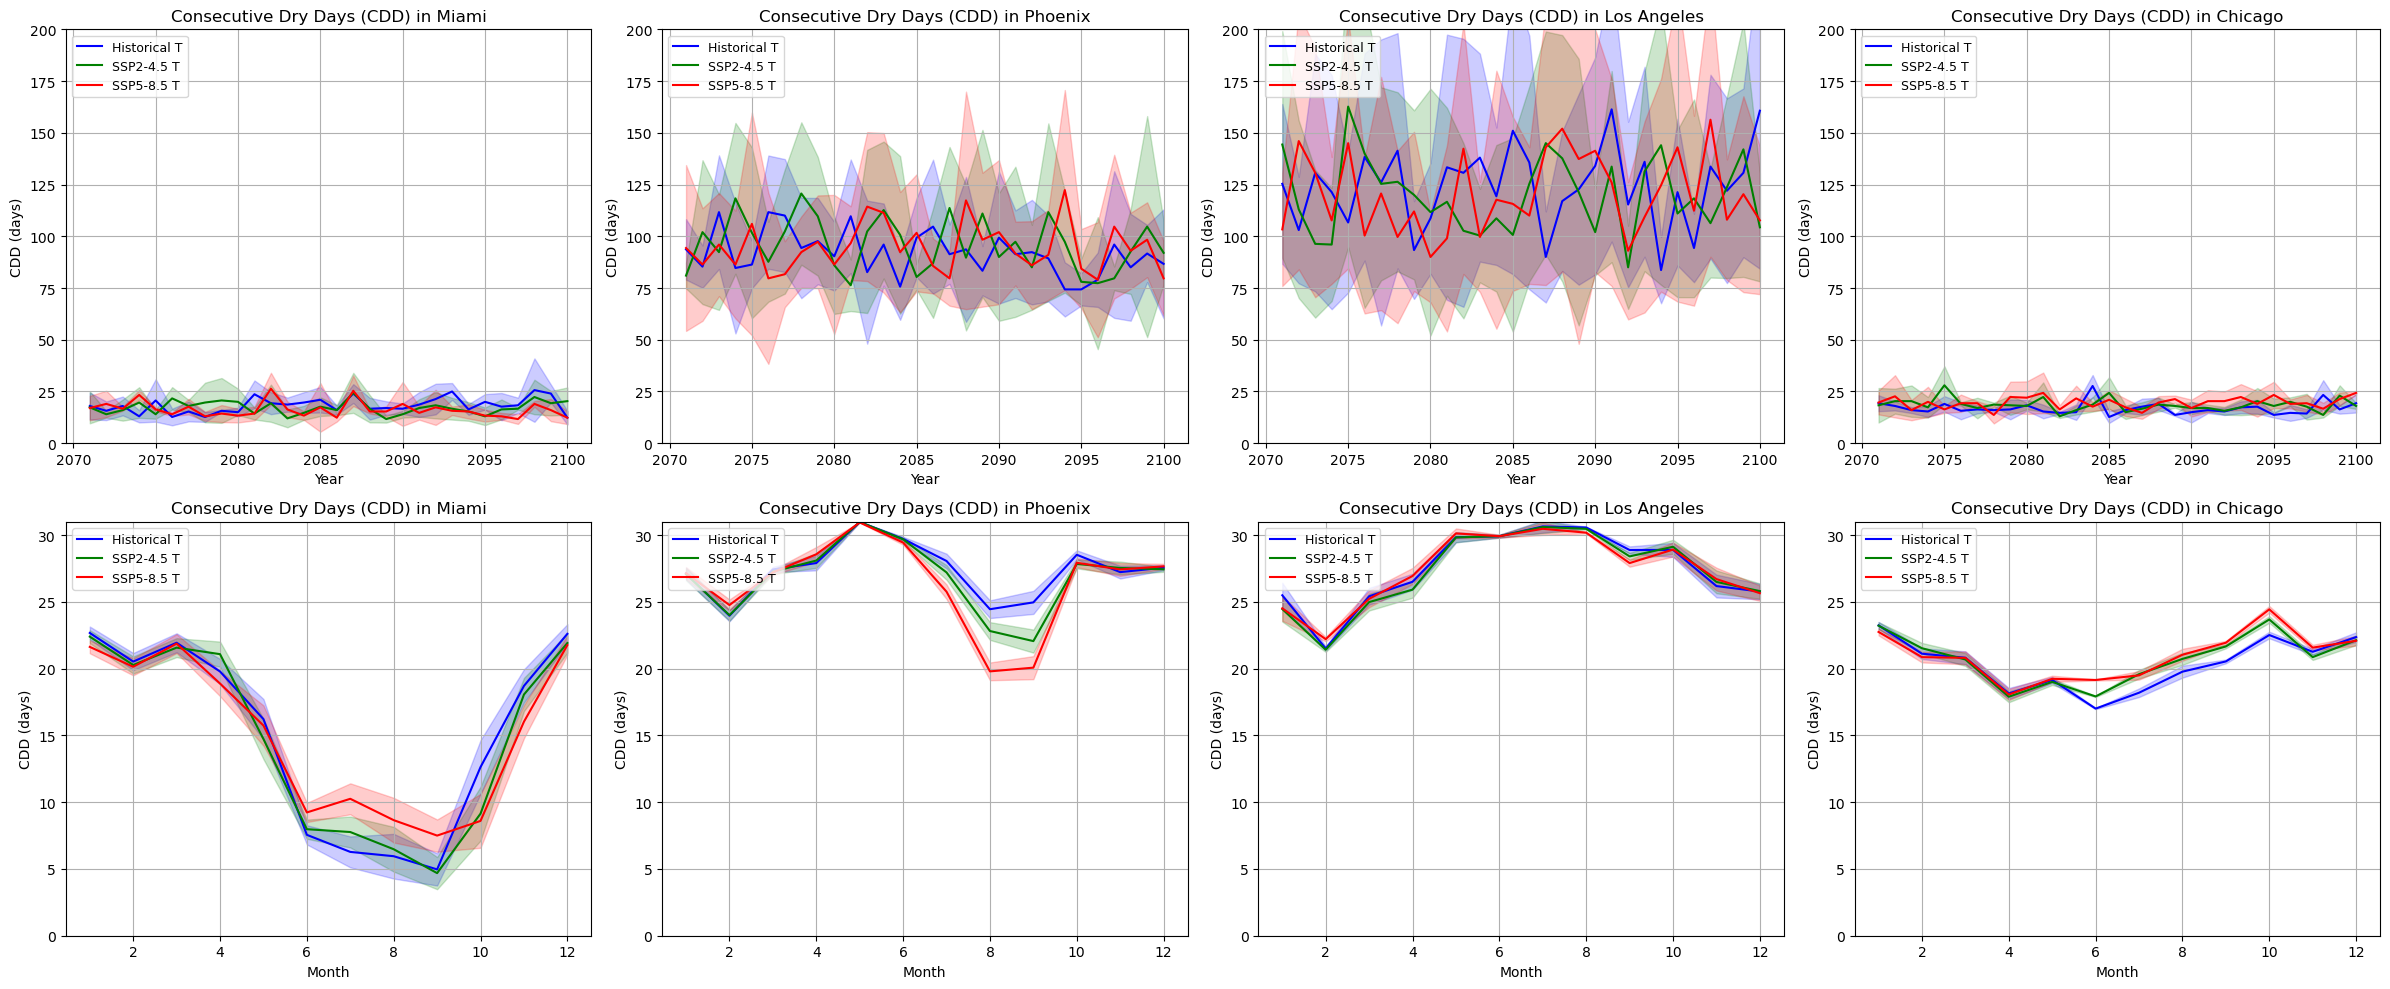

/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv

In [5]:
cities = ['MI', 'PX', 'LA', 'CG']
titles = {'MI': 'Miami', 'PX': 'Phoenix', 'LA': 'Los Angeles', 'CG': 'Chicago'}

fig, axes = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)

for i, city in enumerate(cities):
    hist = xr.open_mfdataset([f'A_{city}_hist.nc', f'G_{city}_hist.nc', f'U_{city}_hist.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    ssp245 = xr.open_mfdataset([f'A_{city}_245.nc', f'G_{city}_245.nc', f'U_{city}_245.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    ssp585 = xr.open_mfdataset([f'A_{city}_585.nc', f'G_{city}_585.nc', f'U_{city}_585.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    
    dry_threshold = 1.0  # mm/day
    pr_hist, pr_245, pr_585 = hist['pr'] * 86400, ssp245['pr'] * 86400, ssp585['pr'] * 86400
    cdd_hist = []
    cdd_245 = []
    cdd_585 = []
    
    for j in range(3):
        pr_hist_model, pr_245_model, pr_585_model = pr_hist.isel(model = j), pr_245.isel(model = j), pr_585.isel(model = j)
        drydays_hist, drydays_245, drydays_585 = pr_hist_model < dry_threshold, pr_245_model < dry_threshold, pr_585_model < dry_threshold
        cdd_hist.append(calculate_cdd(drydays_hist))
        cdd_245.append(calculate_cdd(drydays_245))
        cdd_585.append(calculate_cdd(drydays_585))

    cdd_hist = xr.concat([cdd_hist[0], cdd_hist[1], cdd_hist[2]], dim='model')
    cdd_245 = xr.concat([cdd_245[0], cdd_245[1], cdd_245[2]], dim='model')
    cdd_585 = xr.concat([cdd_585[0], cdd_585[1], cdd_585[2]], dim='model')
    cdd_hist_mean, cdd_245_mean, cdd_585_mean = cdd_hist.mean(dim='model'), cdd_245.mean(dim='model'), cdd_585.mean(dim='model')
    cdd_hist_std, cdd_245_std, cdd_585_std = cdd_hist.std(dim='model'), cdd_245.std(dim='model'), cdd_585.std(dim='model')
    years = cdd_245['year'].values
    
    ax1 = axes[0, i]
    ax1.plot(years, cdd_hist_mean, label='Historical T', color='blue')
    ax1.plot(years, cdd_245_mean, label='SSP2-4.5 T', color='green')
    ax1.plot(years, cdd_585_mean, label='SSP5-8.5 T', color='red')
    ax1.fill_between(years, cdd_hist_mean - cdd_hist_std, cdd_hist_mean + cdd_hist_std, color='blue', alpha=0.2)
    ax1.fill_between(years, cdd_245_mean - cdd_245_std, cdd_245_mean + cdd_245_std, color='green', alpha=0.2)
    ax1.fill_between(years, cdd_585_mean - cdd_585_std, cdd_585_mean + cdd_585_std, color='red', alpha=0.2)

    ax1.set_ylim(0, 200)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('CDD (days)')
    ax1.set_title(f'Consecutive Dry Days (CDD) in {titles[city]}')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True)

    cdd_hist = []
    cdd_245 = []
    cdd_585 = []
    for j in range(3):
        hist_model, ssp245_model, ssp585_model = hist.isel(model = j), ssp245.isel(model = j), ssp585.isel(model = j)
        cdd_hist.append(calculate_monthly_cdd(hist_model))
        cdd_245.append(calculate_monthly_cdd(ssp245_model))
        cdd_585.append(calculate_monthly_cdd(ssp585_model))

    cdd_hist = xr.concat([cdd_hist[0], cdd_hist[1], cdd_hist[2]], dim='model')
    cdd_245 = xr.concat([cdd_245[0], cdd_245[1], cdd_245[2]], dim='model')
    cdd_585 = xr.concat([cdd_585[0], cdd_585[1], cdd_585[2]], dim='model')

    cdd_clim_hist = cdd_hist.cdd_days.groupby('time.month').mean(dim=['time', 'model'])
    cdd_clim_245 = cdd_245.cdd_days.groupby('time.month').mean(dim=['time', 'model'])
    cdd_clim_585 = cdd_585.cdd_days.groupby('time.month').mean(dim=['time', 'model'])
    cdd_clim_hist_std = cdd_hist.cdd_days.groupby('time.month').mean(dim='time').std(dim='model')
    cdd_clim_245_std = cdd_hist.cdd_days.groupby('time.month').mean(dim='time').std(dim='model')
    cdd_clim_585_std = cdd_hist.cdd_days.groupby('time.month').mean(dim='time').std(dim='model')
    
    months = cdd_clim_hist['month'].values
    ax1 = axes[1, i]
    ax1.plot(months, cdd_clim_hist, label='Historical T', color='blue')
    ax1.plot(months, cdd_clim_245, label='SSP2-4.5 T', color='green')
    ax1.plot(months, cdd_clim_585, label='SSP5-8.5 T', color='red')
    ax1.fill_between(months, cdd_clim_hist - cdd_clim_hist_std, cdd_clim_hist + cdd_clim_hist_std, color='blue', alpha=0.2)
    ax1.fill_between(months, cdd_clim_245 - cdd_clim_245_std, cdd_clim_245 + cdd_clim_245_std, color='green', alpha=0.2)
    ax1.fill_between(months, cdd_clim_585 - cdd_clim_585_std, cdd_clim_585 + cdd_clim_585_std, color='red', alpha=0.2)

    ax1.set_ylim(0, 31)
    ax1.set_xlabel('Month')
    ax1.set_ylabel('CDD (days)')
    ax1.set_title(f'Consecutive Dry Days (CDD) in {titles[city]}')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True)

plt.tight_layout()
plt.show()

# 3. "Wonkiness" of Future Climate

## 3.1 Inter-annual and Intra-annual variability

/tmp/ipykernel_7931/1476073921.py:103: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


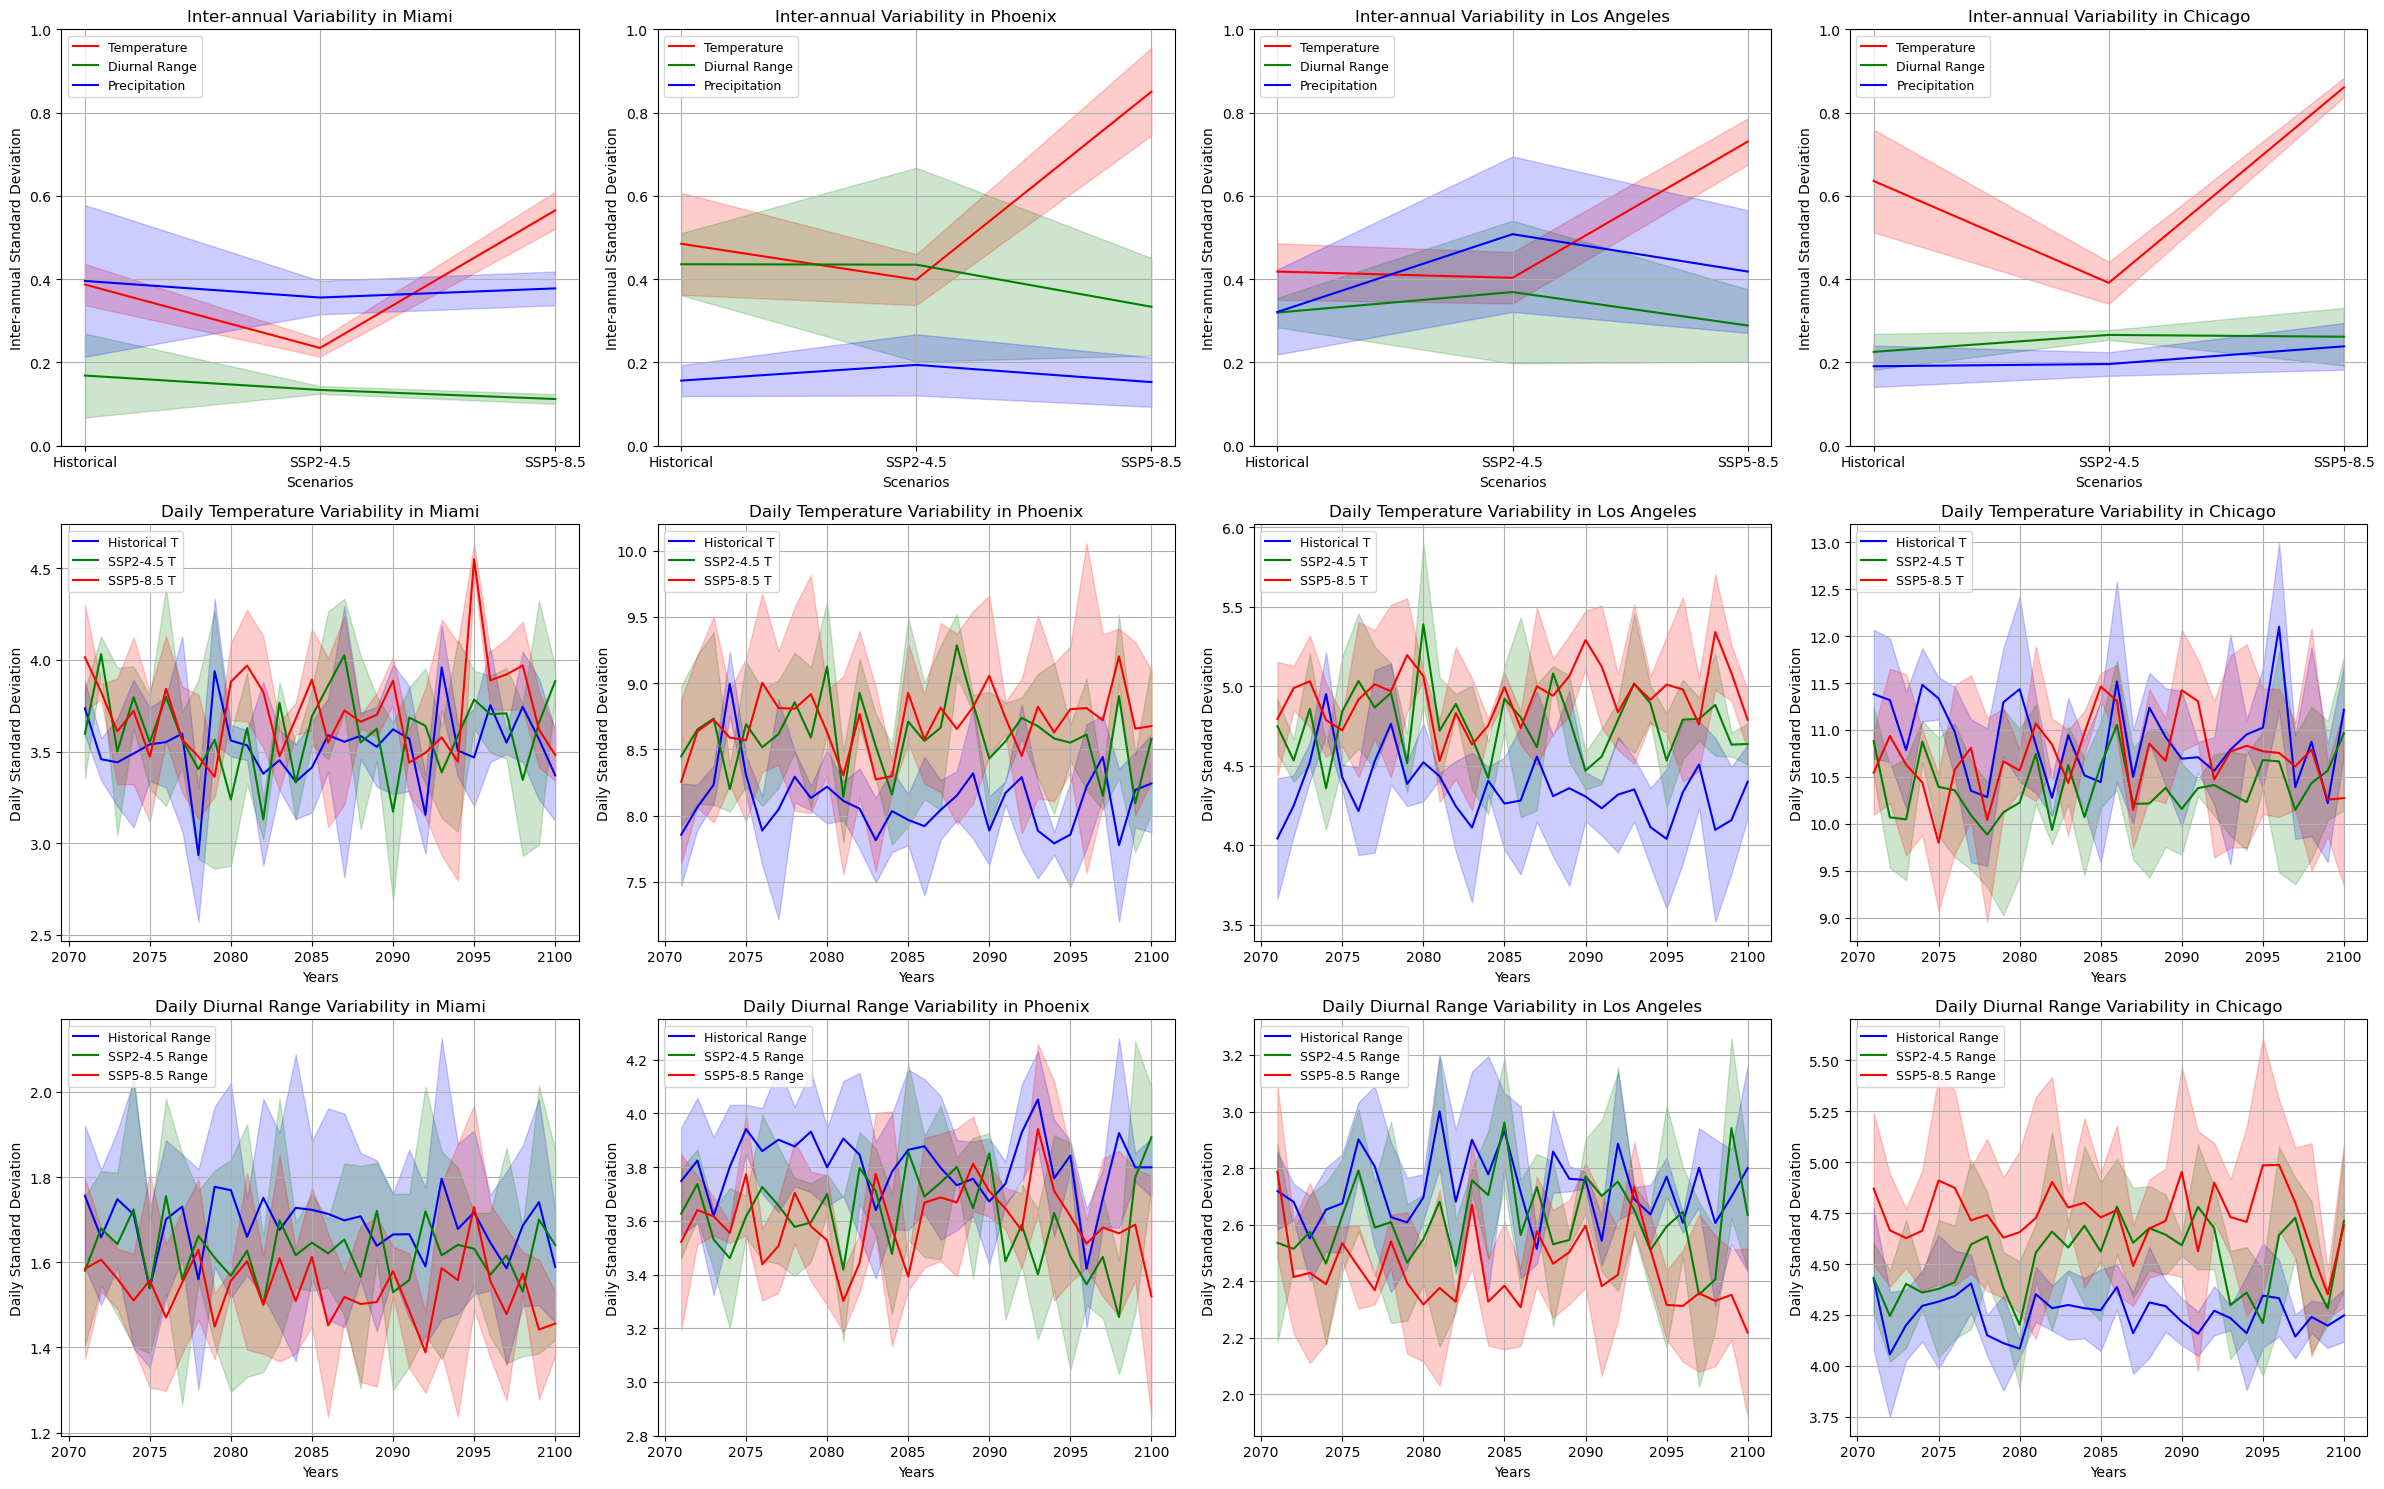

In [6]:
cities = ['MI', 'PX', 'LA', 'CG']
titles = {'MI': 'Miami', 'PX': 'Phoenix', 'LA': 'Los Angeles', 'CG': 'Chicago'}
parameters = ['tas', 'range', 'pr']
names = {'tas': 'Temperature', 'range': 'Diurnal Range', 'pr': 'Precipitation'}

fig, axes = plt.subplots(3, 4, figsize=(24, 15), constrained_layout=True)

for i, city in enumerate(cities):
    hist = xr.open_mfdataset([f'A_{city}_hist.nc', f'G_{city}_hist.nc', f'U_{city}_hist.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    ssp245 = xr.open_mfdataset([f'A_{city}_245.nc', f'G_{city}_245.nc', f'U_{city}_245.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    ssp585 = xr.open_mfdataset([f'A_{city}_585.nc', f'G_{city}_585.nc', f'U_{city}_585.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')

    # 1st line: Inter-annual
    for j, parameter in enumerate(parameters):
        if j < 2:
            annual_std_hist = hist[parameter].groupby('time.year').mean(dim=['time', 'model']).std(dim='year')
            annual_std_245 = ssp245[parameter].groupby('time.year').mean(dim=['time', 'model']).std(dim='year')
            annual_std_585 = ssp585[parameter].groupby('time.year').mean(dim=['time', 'model']).std(dim='year')
            annual_std_hist_std = hist[parameter].groupby('time.year').mean(dim='time').std(dim='year').std(dim='model')
            annual_std_245_std = ssp245[parameter].groupby('time.year').mean(dim='time').std(dim='year').std(dim='model')
            annual_std_585_std = ssp585[parameter].groupby('time.year').mean(dim='time').std(dim='year').std(dim='model')
        else:
            annual_std_hist = (hist[parameter] * 86400).groupby('time.year').mean(dim=['time', 'model']).std(dim='year')
            annual_std_245 = (ssp245[parameter] * 86400).groupby('time.year').mean(dim=['time', 'model']).std(dim='year')
            annual_std_585 = (ssp585[parameter] * 86400).groupby('time.year').mean(dim=['time', 'model']).std(dim='year')
            annual_std_hist_std = (hist[parameter] * 86400).groupby('time.year').mean(dim='time').std(dim='year').std(dim='model')
            annual_std_245_std = (ssp245[parameter] * 86400).groupby('time.year').mean(dim='time').std(dim='year').std(dim='model')
            annual_std_585_std = (ssp585[parameter] * 86400).groupby('time.year').mean(dim='time').std(dim='year').std(dim='model')

        scenarios = ['Historical', 'SSP2-4.5', 'SSP5-8.5']
        tas_annual_variability = [annual_std_hist.values, annual_std_245.values, annual_std_585.values]
        tas_annual_variability_lower = [annual_std_hist.values - annual_std_hist_std.values, annual_std_245.values - annual_std_245_std.values, annual_std_585.values - annual_std_585_std.values]
        tas_annual_variability_upper = [annual_std_hist.values + annual_std_hist_std.values, annual_std_245.values + annual_std_245_std.values, annual_std_585.values + annual_std_585_std.values]
    
        ax1 = axes[0, i]
        if j == 0:
            ax1.plot(scenarios, tas_annual_variability, color='red', label = f'{names[parameter]}')
            ax1.fill_between(scenarios, tas_annual_variability_lower, tas_annual_variability_upper, color='red', alpha=0.2)
        if j == 1:
            ax1.plot(scenarios, tas_annual_variability, color='green', label = f'{names[parameter]}')
            ax1.fill_between(scenarios, tas_annual_variability_lower, tas_annual_variability_upper, color='green', alpha=0.2)
        if j == 2:
            ax1.plot(scenarios, tas_annual_variability, color='blue', label = f'{names[parameter]}')
            ax1.fill_between(scenarios, tas_annual_variability_lower, tas_annual_variability_upper, color='blue', alpha=0.2)
        
        ax1.set_ylim(0, 1)
        ax1.set_xlabel('Scenarios')
        ax1.set_ylabel('Inter-annual Standard Deviation')
        ax1.set_title(f'Inter-annual Variability in {titles[city]}')
        ax1.legend(loc='upper left', fontsize=9)
        ax1.grid(True)


    # 2nd line: Intra-annual Daily tas
    tas_monthly_std_hist = hist['tas'].groupby('time.year').std(dim='time').mean(dim='model')
    tas_monthly_std_245 = ssp245['tas'].groupby('time.year').std(dim='time').mean(dim='model')
    tas_monthly_std_585 = ssp585['tas'].groupby('time.year').std(dim='time').mean(dim='model')
    tas_monthly_std_hist_std = hist['tas'].groupby('time.year').std(dim='time').std(dim='model')
    tas_monthly_std_245_std = ssp245['tas'].groupby('time.year').std(dim='time').std(dim='model')
    tas_monthly_std_585_std = ssp585['tas'].groupby('time.year').std(dim='time').std(dim='model')

    ax1 = axes[1, i]
    years = tas_monthly_std_245['year'].values
    ax1.plot(years, tas_monthly_std_hist, label='Historical T', color='blue')
    ax1.plot(years, tas_monthly_std_245, label='SSP2-4.5 T', color='green')
    ax1.plot(years, tas_monthly_std_585, label='SSP5-8.5 T', color='red')
    ax1.fill_between(years, tas_monthly_std_hist - tas_monthly_std_hist_std, tas_monthly_std_hist + tas_monthly_std_hist_std, color='blue', alpha=0.2)
    ax1.fill_between(years, tas_monthly_std_245 - tas_monthly_std_245_std, tas_monthly_std_245 + tas_monthly_std_245_std, color='green', alpha=0.2)
    ax1.fill_between(years, tas_monthly_std_585 - tas_monthly_std_585_std, tas_monthly_std_585 + tas_monthly_std_585_std, color='red', alpha=0.2)
        
    # ax1.set_ylim(2, 13)
    ax1.set_xlabel('Years')
    ax1.set_ylabel('Daily Standard Deviation')
    ax1.set_title(f'Daily Temperature Variability in {titles[city]}')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True)


    # 3rd line: Intra-annual Daily Diurnal Range
    range_monthly_std_hist = hist['range'].groupby('time.year').std(dim='time').mean(dim='model')
    range_monthly_std_245 = ssp245['range'].groupby('time.year').std(dim='time').mean(dim='model')
    range_monthly_std_585 = ssp585['range'].groupby('time.year').std(dim='time').mean(dim='model')
    range_monthly_std_hist_std = hist['range'].groupby('time.year').std(dim='time').std(dim='model')
    range_monthly_std_245_std = ssp245['range'].groupby('time.year').std(dim='time').std(dim='model')
    range_monthly_std_585_std = ssp585['range'].groupby('time.year').std(dim='time').std(dim='model')

    ax1 = axes[2, i]
    years = range_monthly_std_245['year'].values
    ax1.plot(years, range_monthly_std_hist, label='Historical Range', color='blue')
    ax1.plot(years, range_monthly_std_245, label='SSP2-4.5 Range', color='green')
    ax1.plot(years, range_monthly_std_585, label='SSP5-8.5 Range', color='red')
    ax1.fill_between(years, range_monthly_std_hist - range_monthly_std_hist_std, range_monthly_std_hist + range_monthly_std_hist_std, color='blue', alpha=0.2)
    ax1.fill_between(years, range_monthly_std_245 - range_monthly_std_245_std, range_monthly_std_245 + range_monthly_std_245_std, color='green', alpha=0.2)
    ax1.fill_between(years, range_monthly_std_585 - range_monthly_std_585_std, range_monthly_std_585 + range_monthly_std_585_std, color='red', alpha=0.2)
        
    # ax1.set_ylim(0, 5)
    ax1.set_xlabel('Years')
    ax1.set_ylabel('Daily Standard Deviation')
    ax1.set_title(f'Daily Diurnal Range Variability in {titles[city]}')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True)

plt.tight_layout()
plt.show()

## 3.2 Seasonal Variability

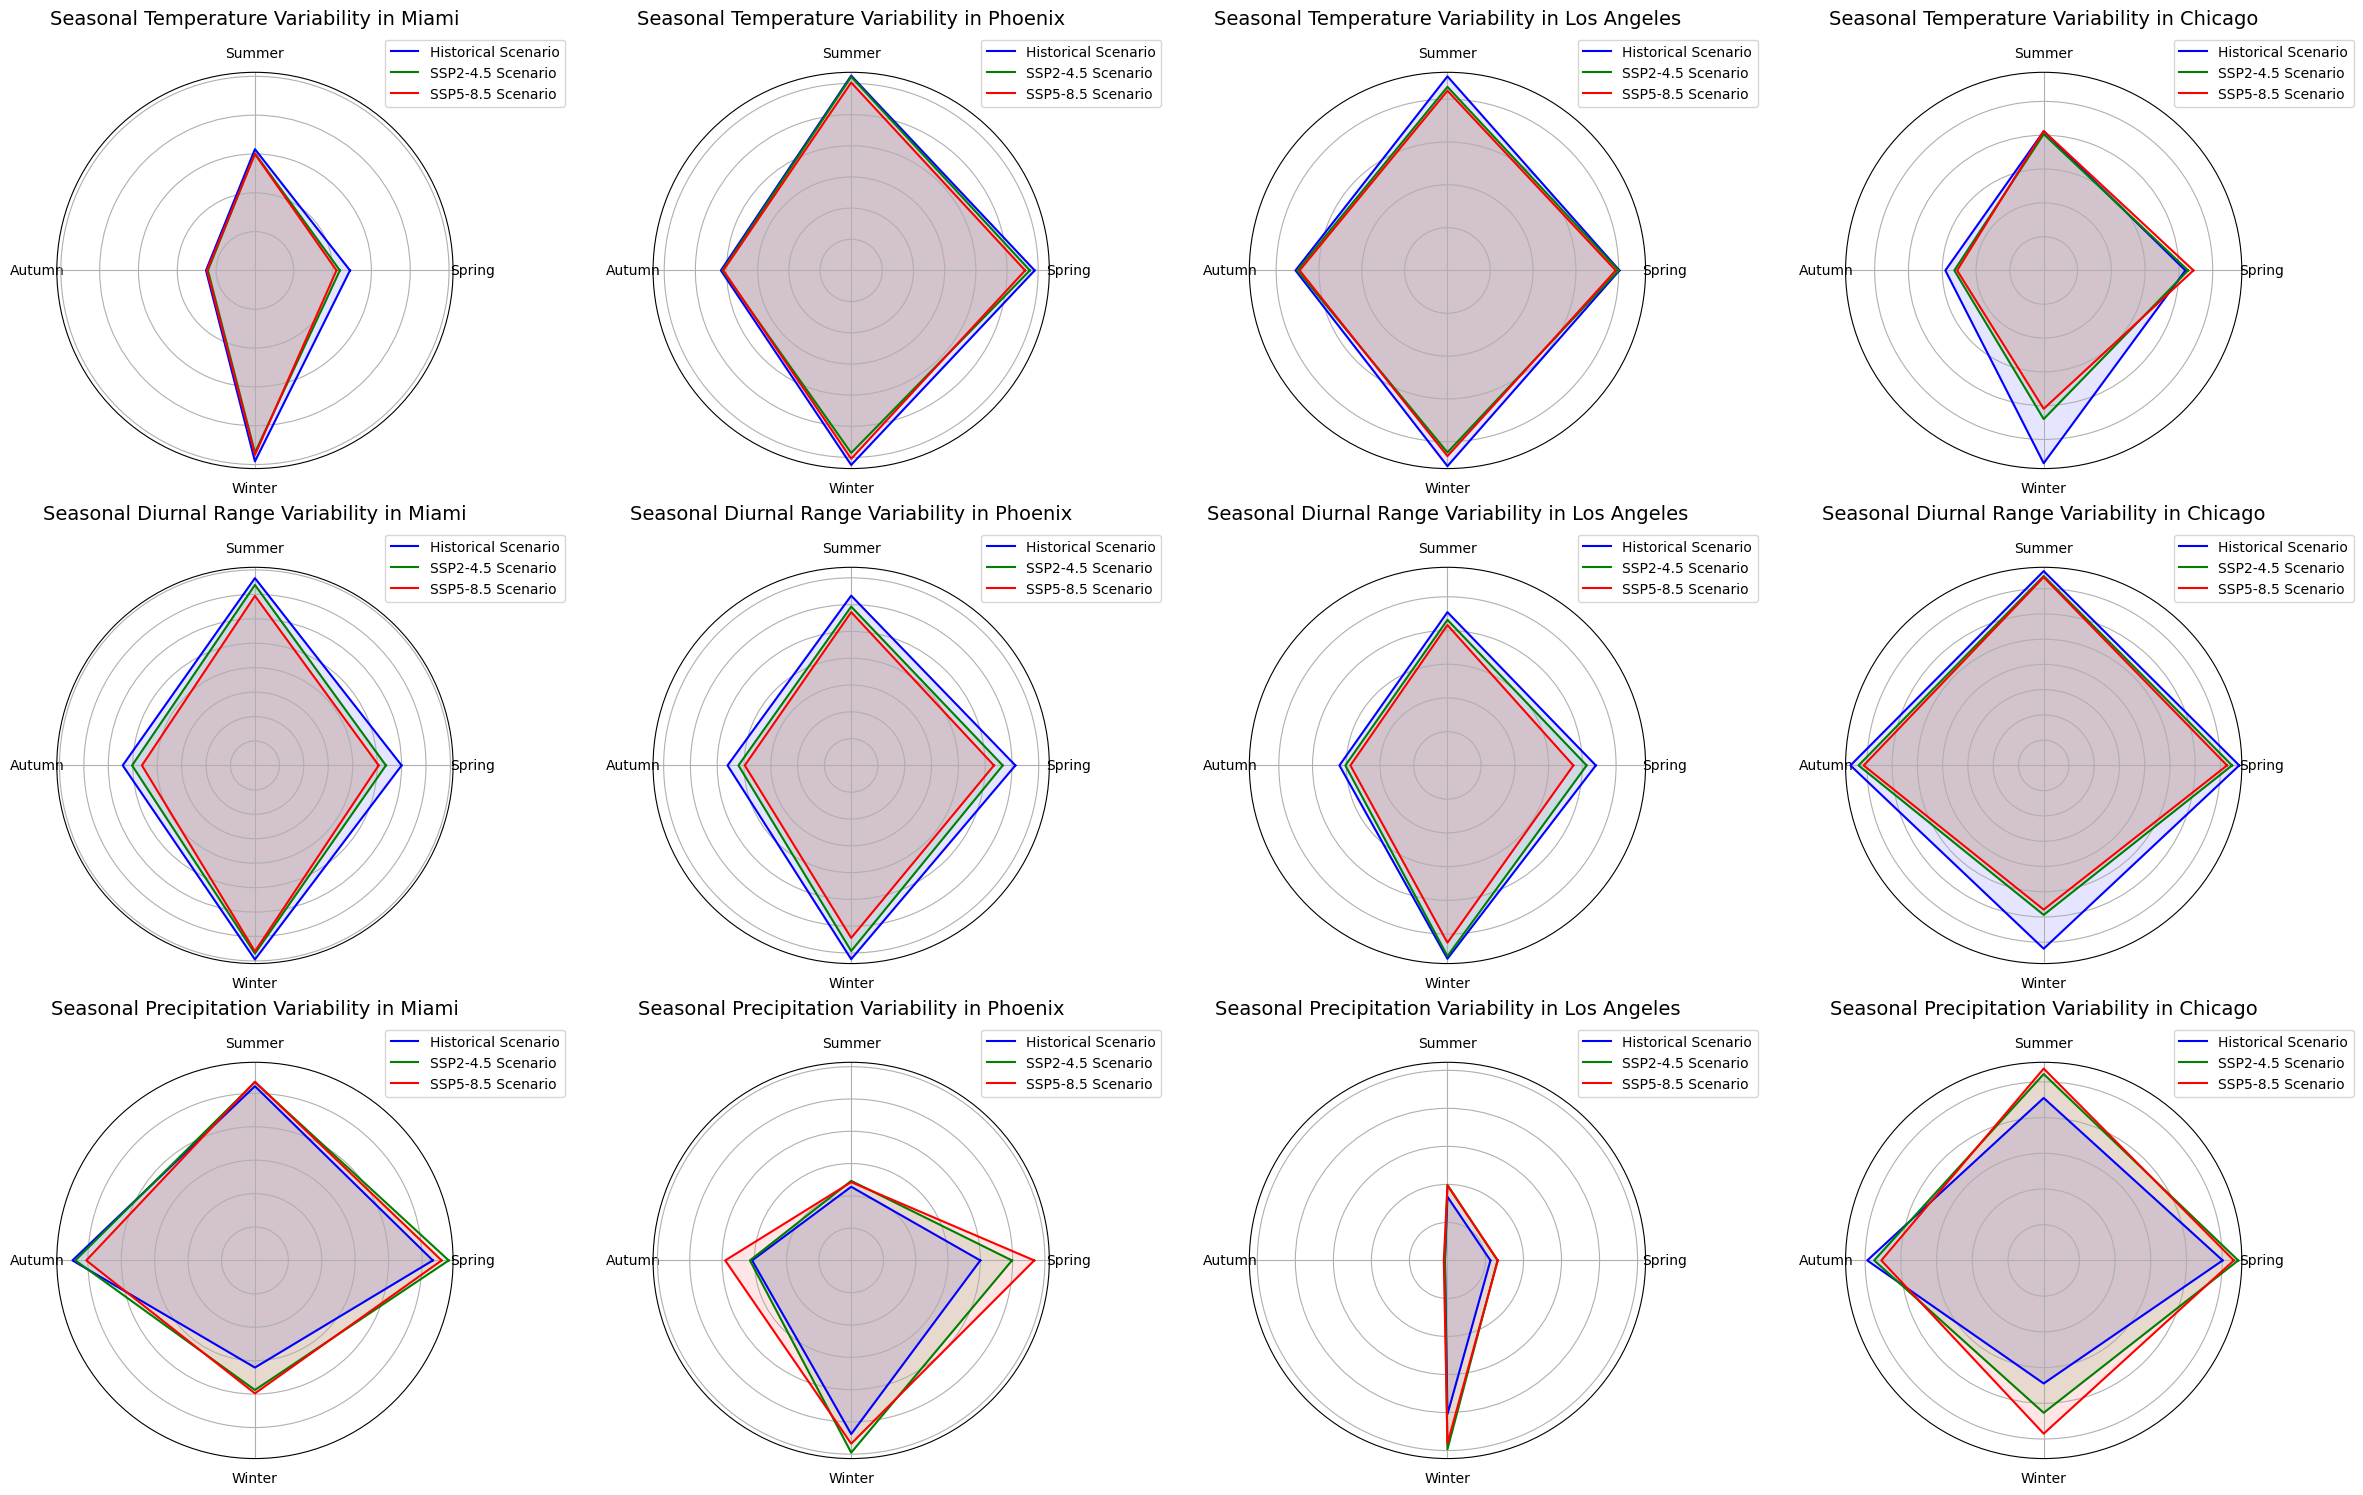

In [13]:
cities = ['MI', 'PX', 'LA', 'CG']
titles = {'MI': 'Miami', 'PX': 'Phoenix', 'LA': 'Los Angeles', 'CG': 'Chicago'}
parameters = ['tas', 'range', 'pr']
names = {'tas': 'Temperature', 'range': 'Diurnal Range', 'pr': 'Precipitation'}
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
categories = len(seasons)

fig, axes = plt.subplots(3, 4, figsize=(24, 15), subplot_kw=dict(polar=True))

for i, city in enumerate(cities):

    hist = xr.open_mfdataset([f'A_{city}_hist.nc', f'G_{city}_hist.nc', f'U_{city}_hist.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    ssp245 = xr.open_mfdataset([f'A_{city}_245.nc', f'G_{city}_245.nc', f'U_{city}_245.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    ssp585 = xr.open_mfdataset([f'A_{city}_585.nc', f'G_{city}_585.nc', f'U_{city}_585.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    
    for j, parameter in enumerate(parameters):
        if j < 2:
            monthly_std_hist = hist[parameter].resample(time='1ME').std().groupby('time.month').mean(dim=['time', 'model'])
            monthly_std_245 = ssp245[parameter].resample(time='1ME').std().groupby('time.month').mean(dim=['time', 'model'])
            monthly_std_585 = ssp585[parameter].resample(time='1ME').std().groupby('time.month').mean(dim=['time', 'model'])
    
        else:
            monthly_std_hist = (hist[parameter] * 86400).resample(time='1ME').std().groupby('time.month').mean(dim=['time', 'model'])
            monthly_std_245 = (ssp245[parameter] * 86400).resample(time='1ME').std().groupby('time.month').mean(dim=['time', 'model'])
            monthly_std_585 = (ssp585[parameter] * 86400).resample(time='1ME').std().groupby('time.month').mean(dim=['time', 'model'])
    
        season_mapping = {
            12: 'Winter', 1: 'Winter', 2: 'Winter',
            3: 'Spring', 4: 'Spring', 5: 'Spring',
            6: 'Summer', 7: 'Summer', 8: 'Summer',
            9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
        }
    
        tas_hist_seasonal_std = monthly_std_hist.to_pandas().groupby(season_mapping).mean()
        tas_245_seasonal_std = monthly_std_245.to_pandas().groupby(season_mapping).mean()
        tas_585_seasonal_std = monthly_std_585.to_pandas().groupby(season_mapping).mean()
    
        values_hist = tas_hist_seasonal_std.values.tolist() + [tas_hist_seasonal_std.values[0]]
        values_245 = tas_245_seasonal_std.values.tolist() + [tas_245_seasonal_std.values[0]]
        values_585 = tas_585_seasonal_std.values.tolist() + [tas_585_seasonal_std.values[0]]
        
        angles = np.linspace(0, 2 * np.pi, categories, endpoint=False).tolist()
        angles += angles[:1]
    
        ax = axes[j, i]
        ax.plot(angles, values_hist, linewidth=1.5, linestyle='solid', label='Historical Scenario', color='blue')
        ax.fill(angles, values_hist, alpha=0.1, color='blue')
    
        ax.plot(angles, values_245, linewidth=1.5, linestyle='solid', label='SSP2-4.5 Scenario', color='green')
        ax.fill(angles, values_245, alpha=0.1, color='green')
    
        ax.plot(angles, values_585, linewidth=1.5, linestyle='solid', label='SSP5-8.5 Scenario', color='red')
        ax.fill(angles, values_585, alpha=0.1, color='red')
    
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(seasons)
        ax.set_yticklabels([])
        ax.set_title(f'Seasonal {names[parameter]} Variability in {titles[city]}', y=1.1, fontsize=12)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

## 3.3 "Wonkiness" Index
#### Ratio of 30-year average of future annual daily temperature/precipitation standard deviation to that of historical period

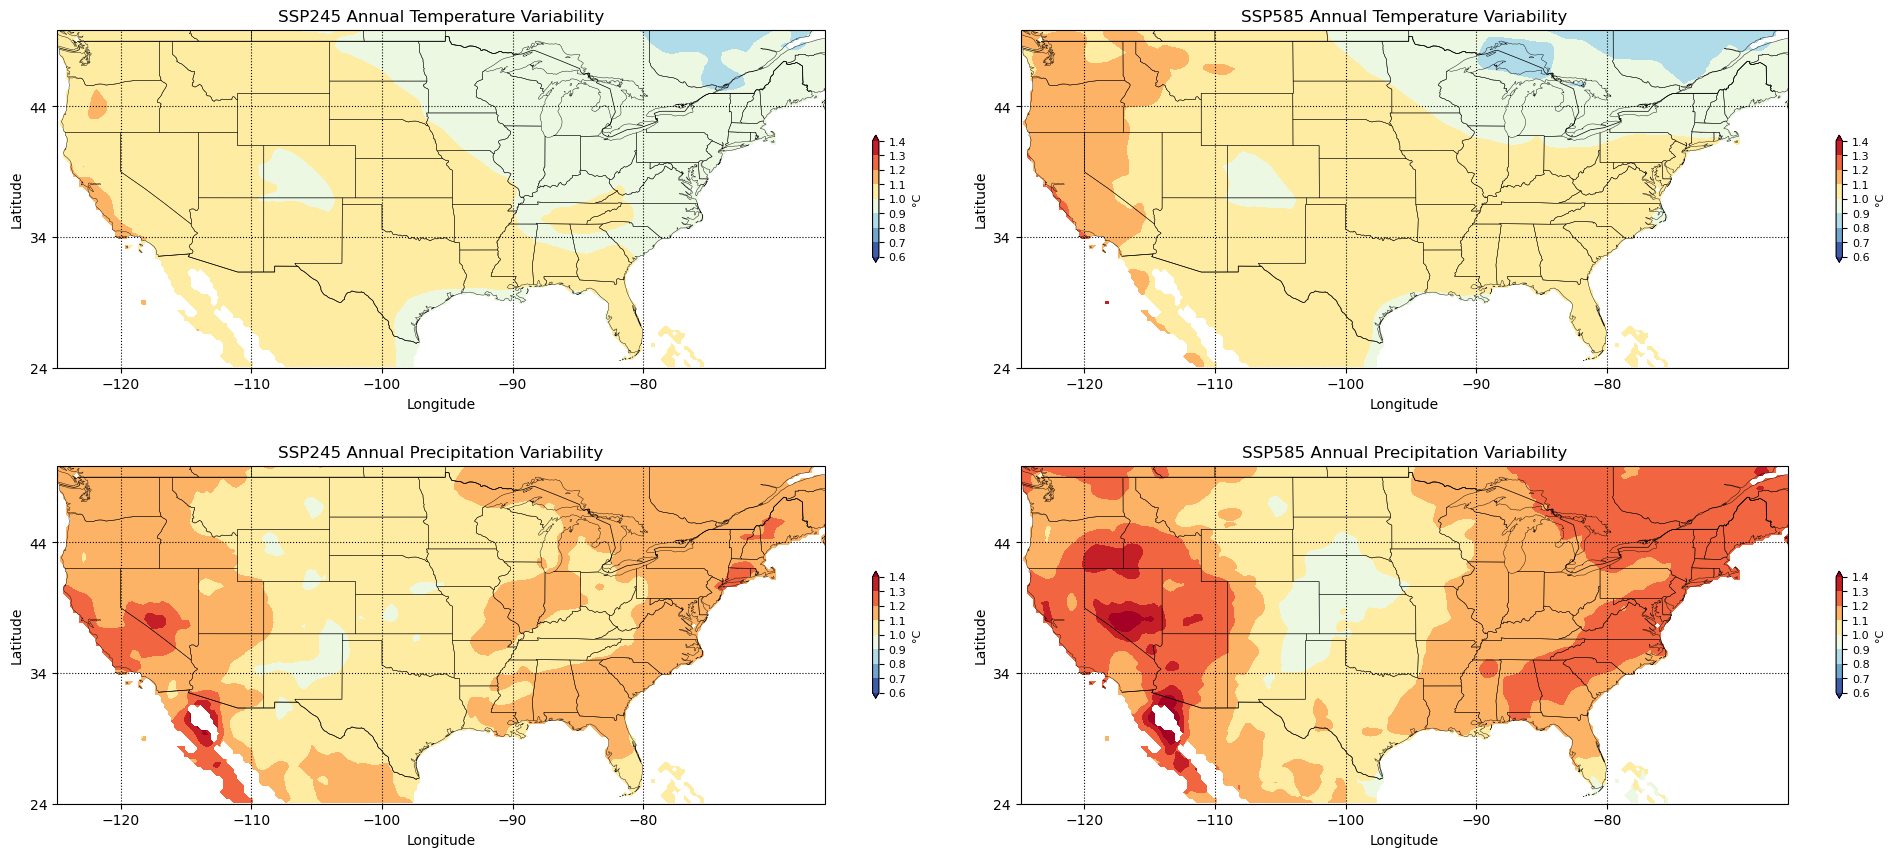

In [15]:
scenarios = ['245', '585']

fig, axes = plt.subplots(2, 2, figsize=(20, 9), subplot_kw={'projection': ccrs.PlateCarree()})

for i, scenario in enumerate(scenarios):
    hist = xr.open_mfdataset(['A_us_hist_2.nc', 'G_us_hist_2.nc', 'U_us_hist_2.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    ssp = xr.open_mfdataset([f'A_us_{scenario}_2.nc', f'G_us_{scenario}_2.nc', f'U_us_{scenario}_2.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')    

    tas_wonkiness = ssp['tas'].groupby('time.year').std(dim='time').mean(dim=['year', 'model']) / hist['tas'].groupby('time.year').std(dim='time').mean(dim=['year', 'model'])

    #1st line: tas
    ax1 = axes[0, i]
    lon = ssp.lon.values
    lat = ssp.lat.values
    clevels = np.arange(0.6, 1.5, 0.1)
    c0 = ax1.contourf(lon, lat, tas_wonkiness, clevels, cmap='RdYlBu_r', extend='both')
    ax1.grid(linestyle=':', linewidth=0.8, color='k')
    ax1.set_xlabel('Longitude', fontsize=10)
    ax1.set_ylabel('Latitude', fontsize=10)
    ax1.set_title(f'SSP{scenario} Average Annual Temperature Variability (2071-2100)', fontsize=12)
    ax1.set_xticks(np.arange(-120, -70, 10), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(24, 50, 10), crs=ccrs.PlateCarree())
    ax1.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax1.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
    cbar = fig.colorbar(c0, ax=ax1, shrink=0.3)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('°C', fontsize=8)

    #2nd line: precip
    pr_wonkiness = ssp['pr'].groupby('time.year').std(dim='time').mean(dim=['year', 'model']) / hist['pr'].groupby('time.year').std(dim='time').mean(dim=['year', 'model'])
    ax1 = axes[1, i]
    lon = ssp.lon.values
    lat = ssp.lat.values
    clevels = np.arange(0.6, 1.5, 0.1)
    c0 = ax1.contourf(lon, lat, pr_wonkiness, clevels, cmap='RdYlBu_r', extend='both')
    ax1.grid(linestyle=':', linewidth=0.8, color='k')
    ax1.set_xlabel('Longitude', fontsize=10)
    ax1.set_ylabel('Latitude', fontsize=10)
    ax1.set_title(f'SSP{scenario} Average Annual Precipitation Variability (2071-2100)', fontsize=12)
    ax1.set_xticks(np.arange(-120, -70, 10), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(24, 50, 10), crs=ccrs.PlateCarree())
    ax1.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax1.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
    cbar = fig.colorbar(c0, ax=ax1, shrink=0.3)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('°C', fontsize=8)

plt.tight_layout()
plt.show()

## 3.4 Model Uncertainty
#### Ratio of the standard deviation brought by different models to the overall standard deviation

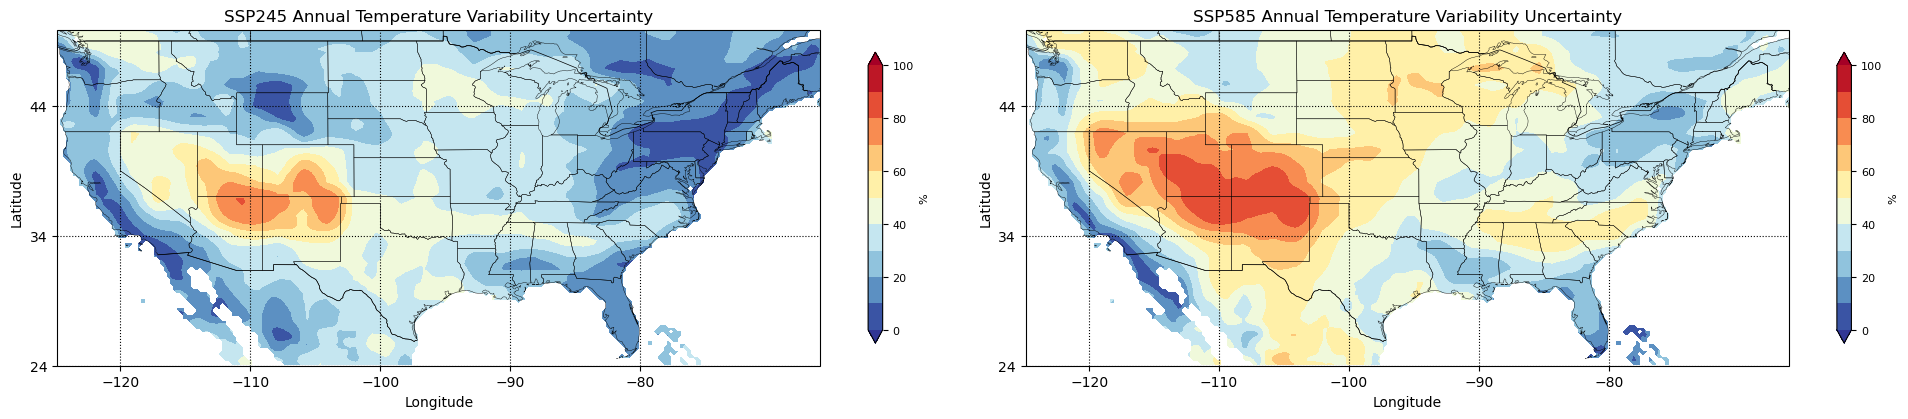

In [9]:
scenarios = ['245', '585']

fig, axes = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

for i, scenario in enumerate(scenarios):
    hist = xr.open_mfdataset(['A_us_hist_2.nc', 'G_us_hist_2.nc', 'U_us_hist_2.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')
    ssp = xr.open_mfdataset([f'A_us_{scenario}_2.nc', f'G_us_{scenario}_2.nc', f'U_us_{scenario}_2.nc'], preprocess=preprocess_dataset, combine='nested', concat_dim='model')    

    tas_future_yearly_std = ssp['tas'].groupby('time.year').std(dim='time') 
    tas_hist_yearly_std = hist['tas'].groupby('time.year').std(dim='time') 
    tas_hist_yearly_std['year'] = tas_future_yearly_std['year']
    
    tas_wonkiness = tas_future_yearly_std.mean(dim=['year', 'model']) / tas_hist_yearly_std.mean(dim=['year', 'model'])

    tas_wonkiness_yearly_mean = tas_future_yearly_std / tas_hist_yearly_std 
    tas_wonkiness_std = tas_wonkiness_yearly_mean.std(dim=['year', 'model']) 
    tas_wonkiness_std_model = tas_wonkiness_yearly_mean.mean(dim='year').std(dim='model')
    tas_wonkiness_uncertainty = 100 * tas_wonkiness_std_model / tas_wonkiness_std
    
    ax1 = axes[i]
    lon = ssp.lon.values
    lat = ssp.lat.values
    clevels = np.arange(0, 110, 10)
    c0 = ax1.contourf(lon, lat, tas_wonkiness_uncertainty, clevels, cmap='RdYlBu_r', extend='both')
    ax1.grid(linestyle=':', linewidth=0.8, color='k')
    ax1.set_xlabel('Longitude', fontsize=10)
    ax1.set_ylabel('Latitude', fontsize=10)
    ax1.set_title(f'SSP{scenario} Annual Temperature Variability Uncertainty', fontsize=12)
    ax1.set_xticks(np.arange(-120, -70, 10), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(24, 50, 10), crs=ccrs.PlateCarree())
    ax1.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax1.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
    cbar = fig.colorbar(c0, ax=ax1, shrink=0.3)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('%', fontsize=8)

plt.tight_layout()
plt.show()

# Conclusion
## Impact of Humidity on Heat Stress
#### Future humidity change will mostly bring cooling effects and reduce humid heat stress, except for cities in middle-western areas.
## Frequency and Risks of Extreme Events
#### Heatwave events will increase for all, while extreme precipitation varies by cities and seasons.
## “Wonkiness” and Instability of City Climatology
#### Wonkiness of city climatology will generally increase especially under the high emission scenario, but the great uncertainty in future projections must be taken into account.